# Imports

In [1]:
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
from pathlib import Path
from collections import Counter
import itertools
import math
import os

from scipy.sparse import csr_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer

from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR

import pickle

from tqdm.auto import tqdm
from IPython.display import display
import matplotlib.pyplot as plt
import wandb

import gc
import weakref

if torch.cuda.is_available():
    device = torch.device("cuda") 
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.mps.set_per_process_memory_fraction(0.9) # Memory usage limit for MacOS
    torch.mps.empty_cache() 
else:
    device = torch.device("cpu")

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(911)
random.seed(911)

device

device(type='mps')

**For cleaning memory**

In [3]:
for obj in gc.get_objects():
    try:
        if isinstance(obj, torch.Tensor) and obj.is_mps: # or obj.is_cuda
            ref = weakref.ref(obj)
            del obj
            del ref
    except ReferenceError:
        pass

gc.collect()
torch.mps.empty_cache() # or torch.cuda.empty_cache()

# Data

In [5]:
file_path = Path().resolve() # Path(__file__).resolve()
project_dir = file_path.parent
raw_data_path = project_dir / 'data' / 'raw'
products_data_dir = project_dir / 'data' / 'processed' / 'products_data'
interim_data_dir = project_dir / 'data' / 'interim'
models_outputs_dir = project_dir / 'data' / 'processed' / 'models_outputs'
models_dir = project_dir / 'models'
processed_images_dir = products_data_dir / 'processed_images_224x224'

raw_data_path.mkdir(parents=True, exist_ok=True)
products_data_dir.mkdir(parents=True, exist_ok=True)
interim_data_dir.mkdir(parents=True, exist_ok=True)
models_outputs_dir.mkdir(parents=True, exist_ok=True)
models_dir.mkdir(parents=True, exist_ok=True)
processed_images_dir.mkdir(parents=True, exist_ok=True)

## Fast Data load (only if data was processed)

In [ ]:
# df_products_articul = pd.read_parquet(products_data_dir / 'df_products_articul.parquet')
df_sales_articul = pd.read_parquet(products_data_dir / 'df_sales_articul.parquet')

display(df_products_articul.tail(2), df_sales_articul.tail(2))

,articul_encrypred,product_created_at_day,sales_total,CLS_google_vit_huge_patch14_224_in21k,mean_patch_google_vit_huge_patch14_224_in21k,pooled_google_vit_huge_patch14_224_in21k,pooled_microsoft_resnet50,CLS_openai_clip_vit_large_patch14,mean_patch_openai_clip_vit_large_patch14,pooled_openai_clip_vit_large_patch14,embedding_e5_large_v2,embedding_bge_large_en_v15,embedding_nomic_embed_text_v15,articul_encrypred_id
228217,xspvtuqv,18529,9417.00,"[0.1068585216999054, -0.06343062222003937, -0....","[0.017839273437857628, -0.010774536058306694, ...","[-0.24715401232242584, 0.41301143169403076, -0...","[0.3190707266330719, 0.028264325112104416, 0.0...","[0.5622039437294006, -0.4325735867023468, 0.44...","[0.8816746473312378, 0.691596269607544, 0.1884...","[0.2884502708911896, 0.38565462827682495, -0.0...","[0.03428741917014122, -0.06396043300628662, 0....","[0.007279624696820974, 0.006243441719561815, 0...","[-0.036529459059238434, 0.03486456722021103, -...",218574
228218,xtqwuuuy,18530,19380.79,"[0.09790005534887314, -0.03745045466348529, 0....","[0.012738960678689182, -0.002624053042382002, ...","[-0.03077596426010132, 0.19863871857523918, -0...","[0.03357352642342448, 0.0015215009916573763, 0...","[0.5787270814180374, -0.054604075849056244, 0....","[0.7522355616092682, 0.7038511633872986, 0.364...","[-0.0036218371242284775, 0.18161564506590366, ...","[0.03048939537256956, -0.06178726628422737, 0....","[-0.0015129486564546824, 0.01574902841821313, ...","[0.005874196067452431, 0.08644555881619453, -0...",207628


,anon_id_encrypred,articul_encrypred,order_date,store_encoded,articul_encrypred_id,sales_total
3354708,wyyyyqqsyyvxvvtr,wyuutrv,2020-08-17,3,69858,453198
3354709,wyyyyqqsyyvxvvtr,wywqryu,2020-07-15,3,129264,155835


## Products Data

In [4]:
df_products = pd.read_parquet(products_data_dir / 'products_data.parquet')
df_products.tail(2)

,articul_encrypred,color_base,brand,ktt1,ktt2,ktt3,ktt4,title,product_id,product_created_at,slug,photo_analytics,sales_total,image_path,CLS_google_vit_huge_patch14_224_in21k,mean_patch_google_vit_huge_patch14_224_in21k,pooled_google_vit_huge_patch14_224_in21k,pooled_microsoft_resnet50,CLS_openai_clip_vit_large_patch14,mean_patch_openai_clip_vit_large_patch14,pooled_openai_clip_vit_large_patch14,description,embedding_e5_large_v2,embedding_bge_large_en_v15,embedding_nomic_embed_text_v15
306670,wqsvuwy,Разноцветный,Lancel,Товары для женщин,Аксессуары,Платки,Платок шелковый,Шелковый платок,13567982,2020-06-25,6027468-shelkovyi-platok-lancel-raznotcvetnyi-...,https://st-cdn.tsum.com/int/height/1526/i/f5/9...,0.01,/Users/dimi3tru/Downloads/Downloads/my_python_...,"[0.14456921815872192, -0.06249238923192024, -0...","[0.013126503676176071, -0.0019127298146486282,...","[0.22613008320331573, 0.1457078456878662, -0.1...","[0.030423777177929878, 0.0, 0.0, 0.08489743620...","[0.15574012696743011, -0.3459433317184448, 0.6...","[0.6875616312026978, 0.6793960332870483, 0.354...","[0.42158013582229614, 0.2945811450481415, 0.35...",This Lancel silk scarf features shades of blue...,"[0.02612929418683052, -0.05050811171531677, 0....","[-0.020242616534233093, -0.01976708509027958, ...","[0.01306484080851078, 0.022184912115335464, -0..."
306671,ttquswt,Чёрный,Giorgio Armani,Товары для женщин,Бижутерия,Брошь,Брошь,Брошь,11201309,2016-07-26,5504265-brosh-giorgio-armani-chernyi,https://st-cdn.tsum.com/int/height/1526//i/76/...,0.01,/Users/dimi3tru/Downloads/Downloads/my_python_...,"[-0.12436471879482269, -0.030923746526241302, ...","[-0.01337357982993126, -0.0029991380870342255,...","[-0.09756504744291306, -0.15952929854393005, 0...","[0.03119073063135147, 0.0002419875527266413, 0...","[0.5343070030212402, 0.26047518849372864, 0.37...","[0.7018769979476929, 0.5926704406738281, 0.369...","[0.2984030842781067, 0.4144335687160492, -0.12...",This item is a black brooch from Giorgio Arman...,"[0.013706686906516552, -0.061785973608493805, ...","[-0.029468011111021042, 0.002113671973347664, ...","[0.03772303834557533, 0.08191631734371185, -0...."


There are some broken URLs — we remove these items from our dataset.

![alt text](../junk/broken_urls.png)

In [5]:
print(f'Total number of rows initially: {df_products.shape[0]}')
print(f'Number of rows with at least one missing value: {df_products[df_products.isna().any(axis=1)].shape[0]}')

df_products.dropna(inplace=True)
print(f'Number of rows after cleaning: {df_products.shape[0]}')

Total number of rows initially: 306672
Number of rows with at least one missing value: 8
Number of rows after cleaning: 306664


**Переход с ключа `product_id` на ключ `articul_encrypred`**

In [6]:
df = df_products.copy()
del df_products

df['product_created_at_day'] = pd.to_datetime(df['product_created_at']).dt.floor('D')
df['product_created_at_day'] = (df['product_created_at_day'] - pd.Timestamp('1970-01-01')) // pd.Timedelta(days=1)

# Embedding columns
embedding_cols = [col for col in df.columns if any(prefix in col for prefix in ['CLS_', 'mean_patch_', 'pooled_', 'embedding_'])]
agg_dict = {'product_created_at_day': 'min', 
            'sales_total': 'sum'}
# Mean by dimenshion for embeddings
for col in embedding_cols:
    agg_dict[col] = 'mean'
df_products_articul = df.groupby('articul_encrypred').agg(agg_dict).reset_index()

del df

# Create ranked ID by descending sales volume
articul_rank = df_products_articul[['articul_encrypred', 'sales_total']].drop_duplicates().sort_values('sales_total', ascending=False).reset_index(drop=True).assign(articul_encrypred_id=lambda x: x.index + 1)
df_products_articul = df_products_articul.merge(articul_rank[['articul_encrypred', 'articul_encrypred_id']], on='articul_encrypred', how='left')

df_products_articul.to_parquet(products_data_dir / 'df_products_articul.parquet', index=False)
df_products_articul.tail()

,articul_encrypred,product_created_at_day,sales_total,CLS_google_vit_huge_patch14_224_in21k,mean_patch_google_vit_huge_patch14_224_in21k,pooled_google_vit_huge_patch14_224_in21k,pooled_microsoft_resnet50,CLS_openai_clip_vit_large_patch14,mean_patch_openai_clip_vit_large_patch14,pooled_openai_clip_vit_large_patch14,embedding_e5_large_v2,embedding_bge_large_en_v15,embedding_nomic_embed_text_v15,articul_encrypred_id
228214,wyyyxuw,18430,372493.07,"[0.054675329476594925, -0.031218096613883972, ...","[-0.015285112895071507, -0.002974292729049921,...","[-0.10003115236759186, -0.007143696304410696, ...","[0.022604845464229584, 0.008857643231749535, 0...","[-0.005107337608933449, 0.055002182722091675, ...","[0.6566806435585022, 0.8994556665420532, 0.425...","[0.40712353587150574, 0.6740058064460754, -0.0...","[0.026547163724899292, -0.05078291893005371, 0...","[0.010242261923849583, -0.008357411250472069, ...","[-0.01627330109477043, 0.03971276432275772, -0...",80702
228215,wyyyxux,18405,55930.00,"[0.12628699839115143, -0.1826455146074295, -0....","[0.013777711428701878, -0.02734513208270073, -...","[-0.25407537817955017, -0.1469070166349411, -0...","[0.1269151270389557, 0.0, 6.139278411865234e-0...","[0.1935054361820221, 0.6354405879974365, 0.621...","[0.6567713618278503, 0.706050455570221, 0.4033...","[0.5280981063842773, 0.5120133757591248, 0.190...","[0.03120279870927334, -0.04832116514444351, 0....","[-0.02726542204618454, -0.004029609262943268, ...","[-0.024061240255832672, 0.05157441273331642, -...",176363
228216,wyyyxuy,18412,293330.55,"[-0.03089914657175541, 0.0044742790050804615, ...","[0.010508312843739986, 0.01059587299823761, -0...","[-0.01950656808912754, -0.05603202059864998, -...","[0.004777229391038418, 0.0, 0.1000245586037635...","[0.4373447895050049, 0.04957278072834015, 0.67...","[0.8001006245613098, 0.9261599779129028, 0.368...","[0.34528201818466187, 0.702330470085144, 0.210...","[0.01696249097585678, -0.058472465723752975, 0...","[-0.0057455929927527905, -0.000962883175816386...","[0.03578423336148262, 0.022266210988163948, -0...",94224
228217,xspvtuqv,18529,9417.00,"[0.1068585216999054, -0.06343062222003937, -0....","[0.017839273437857628, -0.010774536058306694, ...","[-0.24715401232242584, 0.41301143169403076, -0...","[0.3190707266330719, 0.028264325112104416, 0.0...","[0.5622039437294006, -0.4325735867023468, 0.44...","[0.8816746473312378, 0.691596269607544, 0.1884...","[0.2884502708911896, 0.38565462827682495, -0.0...","[0.03428741917014122, -0.06396043300628662, 0....","[0.007279624696820974, 0.006243441719561815, 0...","[-0.036529459059238434, 0.03486456722021103, -...",218574
228218,xtqwuuuy,18530,19380.79,"[0.09790005534887314, -0.03745045466348529, 0....","[0.012738960678689182, -0.002624053042382002, ...","[-0.03077596426010132, 0.19863871857523918, -0...","[0.03357352642342448, 0.0015215009916573763, 0...","[0.5787270814180374, -0.054604075849056244, 0....","[0.7522355616092682, 0.7038511633872986, 0.364...","[-0.0036218371242284775, 0.18161564506590366, ...","[0.03048939537256956, -0.06178726628422737, 0....","[-0.0015129486564546824, 0.01574902841821313, ...","[0.005874196067452431, 0.08644555881619453, -0...",207628


## Sales Data

In [11]:
df_sales = pd.read_csv(raw_data_path / 'full_orders_v6.csv', sep=None, engine='python')[['anon_id_encrypred', 'articul_encrypred', 'order_date', 'store']]

df_grouped = df_sales.groupby(['anon_id_encrypred', 'articul_encrypred', 'order_date']).agg(lambda x: x.mode().iloc[0]).reset_index() 

# Encode purchase channel
store_encoding = {'E': 1, 'O': 2, 'T': 3, 'D': 4, 'B': 5} 
df_grouped['store_encoded'] = df_grouped['store'].map(store_encoding) 

# Add total sales by articul (sales total calculated in photo_embeddings.py)
df_sales_articul = df_grouped.merge(df_products_articul[['articul_encrypred', 'articul_encrypred_id', 'sales_total']], on='articul_encrypred', how='left')
df_sales_articul.drop(columns='store', inplace=True)

# Drop articul_encrypred which are not represented in df_products_articul
df_sales_articul.dropna(inplace=True)
df_sales_articul['articul_encrypred_id'] = df_sales_articul['articul_encrypred_id'].astype(int)
df_sales_articul['sales_total'] = df_sales_articul['sales_total'].astype(int)

del df_grouped, df_sales

df_sales_articul.to_parquet(products_data_dir / 'df_sales_articul.parquet', index=False)
df_sales_articul.tail(2)

,anon_id_encrypred,articul_encrypred,order_date,store_encoded,articul_encrypred_id,sales_total
3369678,wyyyyqqsyyvxvvtr,wyuutrv,2020-08-17,3,69858,453198
3369679,wyyyyqqsyyvxvvtr,wywqryu,2020-07-15,3,129264,155835


Keep only the products that are present in the df_products dataset.

In [ ]:
# print(f"Unique 'articul_encrypred' values — articul_encrypred: {len(articul_encrypred['articul_encrypred'].unique())}, df_products: {len(df_products['articul_encrypred'].unique())}")
# print(f"Unique 'articul_encrypred' values — df_sales: {len(df_sales['articul_encrypred'].unique())}, df_products: {len(df_products['articul_encrypred'].unique())}")

# df_sales = df_sales.merge(
#     df_products[['articul_encrypred']],
#     on=['articul_encrypred'],
#     how='inner'
# )
# print()
# print(f"Unique 'articul_encrypred' values (after filtering) — df_sales: {len(df_sales['articul_encrypred'].unique())}, df_products: {len(df_products['articul_encrypred'].unique())}")
# print(f"Unique 'articul_encrypred' values (after filtering) — df_sales: {len(df_sales['articul_encrypred'].unique())}, df_products: {len(df_products['articul_encrypred'].unique())}")

# df_sales.to_parquet(interim_data_dir / 'df_sales.parquet', index=False)

Unique 'articul_encrypred' values — df_sales: 234460, df_products: 228219
Unique 'product_id' values — df_sales: 314113, df_products: 306664

Unique 'articul_encrypred' values (after filtering) — df_sales: 228219, df_products: 228219
Unique 'product_id' values (after filtering) — df_sales: 306664, df_products: 306664


In [14]:
# max_purchase_days_per_user = 100  # Maximum number of purchase days allowed per user (a purchase = unique user-day pair)
# min_purchases_per_user = 2       # Minimum number of purchases required per user (a purchase = user-item interaction)

# # Exclude "resellers" — users with too many unique purchase days (e.g., buying 5 items on 1 day = 1 purchase)
# purchase_days = df_sales.groupby('anon_id_encrypred')['order_date'].nunique().reset_index()
# purchase_days.columns = ['anon_id_encrypred', 'unique_purchase_days']
# resellers = purchase_days[purchase_days['unique_purchase_days'] > max_purchase_days_per_user]['anon_id_encrypred']

# # Exclude users with too few purchases (e.g., buying 5 items on 1 day = 5 purchases)
# user_purchase_counts = df_sales['anon_id_encrypred'].value_counts()

# df_sales = (df_sales[~df_sales['anon_id_encrypred'].isin(resellers)]
#                [df_sales['anon_id_encrypred'].isin(user_purchase_counts[user_purchase_counts >= min_purchases_per_user].index)]
#            ).reset_index(drop=True)

# df_sales.tail(2)

# Metrics

In [5]:
def precision_at_k_gpu(loader, k=10, device=device):
    '''
    Computes Precision@K for batched recommendation results using GPU.
    '''
    precision_sum, total_users = 0.0, 0

    with torch.no_grad():
        for batch in tqdm(loader, desc='Precision@K'):
            recs = batch['recs'][:, :k]     # [B, k]
            true_pad = batch['true']        # [B, L]
            true_len = batch['true_len']    # [B]

            # hits_mask: [B, k] – True if the recommended item appears in the ground truth
            # torch.isin performs elementwise comparison: [B, k, L], .any(-1) collapses last dim — "was there at least one match"
            # hits_mask = torch.isin(
            #     recs.unsqueeze(-1),       # [B, k, 1] – add dummy dimension
            #     true_pad.unsqueeze(1)     # [B, 1, L_max] – reshape ground truth
            # ).any(-1)

            # !!! torch.isin with .any is not reliable on MPS (works fine on CUDA and even Mac CPU)
            hits_mask = (recs.unsqueeze(-1) == true_pad.unsqueeze(1)).any(-1)

            hits_cnt = hits_mask.sum(1).float()  # [B] – number of correct recommendations per user
            denom = torch.minimum(true_len.clamp(min=1).float(), torch.tensor(k, device=device))  # min(k, true_len) – avoid penalizing users with few ground truth items
            precision = hits_cnt / denom

            precision_sum += precision.sum().item()
            total_users += recs.size(0)

    return precision_sum / total_users
    

def recall_at_k_gpu(loader, k=10, device=device):
    '''
    Computes Recall@K for batched recommendation results using GPU.
    '''
    recall_sum, total_users = 0.0, 0

    with torch.no_grad():
        for batch in tqdm(loader, desc='Recall@K'):
            recs      = batch['recs'][:, :k]      # [B, k]  top-k recommendations
            true_pad  = batch['true']             # [B, L]  true items, padded with -1
            true_len  = batch['true_len']         # [B]     lengths of true lists

            # hits_mask: [B, k] – True if a recommendation matches any true item
            # torch.isin compares [B, k, 1] with [B, 1, L], resulting in [B, k, L]; .any(-1) collapses over L to detect any match
            # hits_mask = torch.isin(
            #     recs.unsqueeze(-1),       # [B, k, 1] – expand recs
            #     true_pad.unsqueeze(1)     # [B, 1, L] – expand ground truth
            # ).any(-1)

            # !!! torch.isin with .any does not work correctly on MPS (works on CUDA and Mac CPU)
            hits_mask = (recs.unsqueeze(-1) == true_pad.unsqueeze(1)).any(-1)     

            hits_cnt = hits_mask.sum(1).float()    # [B]  number of relevant recommendations

            # recall = hits / |true|; skip users with no true items
            valid_mask = true_len > 0              # [B]  boolean mask
            recall = torch.zeros_like(hits_cnt)
            recall[valid_mask] = hits_cnt[valid_mask] / true_len[valid_mask].float()

            recall_sum  += recall.sum().item()
            total_users += valid_mask.sum().item()

    return recall_sum / total_users
    

def map_at_k_gpu(loader, k=10, device=device):
    '''
    Computes Mean Average Precision (MAP@K) for batched recommendation results using GPU.
    '''
    map_sum, total_users = 0.0, 0
    positions = (torch.arange(k, device=device).float() + 1)  # [1 … k]

    with torch.no_grad():
        for batch in tqdm(loader, desc='MAP@K'):
            recs      = batch['recs'][:, :k]      # [B, k]
            true_pad  = batch['true']             # [B, L]
            true_len  = batch['true_len']         # [B]

            # hits_mask: [B, k] – True if a recommended item is in the ground truth
            # torch.isin performs pairwise comparison and returns [B, k, L]; .any(-1) collapses last dim to check if any match exists
            # hits_mask = torch.isin(
            #     recs.unsqueeze(-1),       # [B, k, 1] – expand recs
            #     true_pad.unsqueeze(1)     # [B, 1, L_max] – expand ground truth
            # ).any(-1)

            # !!! torch.isin with .any does not work correctly on MPS (works fine on CUDA and Mac CPU)
            hits_mask = (recs.unsqueeze(-1) == true_pad.unsqueeze(1)).any(-1)     

            # cum_hits: number of hits encountered up to position j
            cum_hits  = torch.cumsum(hits_mask.float(), dim=1)   # [B, k]

            # precisions@j are computed only at hit positions
            precisions = (cum_hits * hits_mask.float()) / positions  # [B, k]

            # AP = sum of precisions / min(|true|, k)
            denom = torch.minimum(true_len.clamp(min=1).float(), torch.tensor(k, device=device)) # [B]
            ap = precisions.sum(1) / denom # [B]

            map_sum += ap.sum().item()
            total_users += recs.size(0)

    return map_sum / total_users


def ndcg_at_k_gpu(loader, k=10, device=device):
    '''
    Computes Normalized Discounted Cumulative Gain (NDCG@K) for batched recommendation results using GPU.
    '''
    ndcg_sum, total_users = 0.0, 0
    discount = 1.0 / torch.log2(torch.arange(k, device=device).float() + 2)  # [1/log2(i+2)]
    ideal_cum = torch.cumsum(discount, dim=0)                                # prefix sum for IDCG

    with torch.no_grad():
        for batch in tqdm(loader, desc='NDCG@K'):
            recs = batch['recs'][:, :k]        # [B, k]
            true_pad = batch['true']           # [B, L]
            true_len = batch['true_len']       # [B]

            # hits_mask: [B, k] – True if the recommended item appears in the ground truth
            # torch.isin performs elementwise comparison [B, k, L]; .any(-1) checks if at least one match exists per position
            # hits_mask = torch.isin(
            #     recs.unsqueeze(-1),       # [B, k, 1]
            #     true_pad.unsqueeze(1)     # [B, 1, L_max]
            # ).any(-1)

            # !!! torch.isin with .any does not work properly on MPS (works fine on CUDA and Mac CPU)
            hits_mask = (recs.unsqueeze(-1) == true_pad.unsqueeze(1)).any(-1)     

            # DCG: sum of discounted gains at hit positions
            dcg = (hits_mask.float() * discount).sum(1)   # [B]

            # IDCG: maximum possible DCG under ideal ranking
            idcg_len = torch.minimum(true_len, torch.tensor(k, device=device))  # [B]
            idcg = torch.zeros_like(dcg)
            idcg[idcg_len > 0] = ideal_cum[idcg_len[idcg_len > 0] - 1]

            # NDCG = DCG / IDCG (0 if IDCG == 0)
            ndcg = torch.where(idcg > 0, dcg / idcg, torch.zeros_like(dcg))

            ndcg_sum += ndcg.sum().item()
            total_users += recs.size(0)

    return ndcg_sum / total_users


In [6]:
def log_model_results(model_name, precision_k, recall_k, map_k, ndcg_k, k, hyperparameters=None, round_level=4):
    '''
    Appends model evaluation results to the dataframe.
    
    model_name: str – name of the model
    precision_k, recall_k, map_k, ndcg_k: torch.Tensor or float – evaluation metrics
    k: int – value of K used in metrics
    hyperparameters: dict – model hyperparameters (optional)
    round_level: int – number of decimal places to round to (default is 4)
    '''
    global df_metrics
    
    # Convert tensors to floats and round them (if they are tensors)
    precision_k = round(precision_k.item() if isinstance(precision_k, torch.Tensor) else precision_k, round_level)
    recall_k = round(recall_k.item() if isinstance(recall_k, torch.Tensor) else recall_k, round_level)
    map_k = round(map_k.item() if isinstance(map_k, torch.Tensor) else map_k, round_level)
    ndcg_k = round(ndcg_k.item() if isinstance(ndcg_k, torch.Tensor) else ndcg_k, round_level)
    
    new_row = pd.DataFrame([{
        'Model': model_name,
        'k': k,
        'Precision@k': precision_k,
        'Recall@k': recall_k,
        'MAP@k': map_k,
        'NDCG@k': ndcg_k,
        'Other_hyperparameters': hyperparameters
    }])
    
    df_metrics = pd.concat([df_metrics, new_row], ignore_index=True)

df_metrics = pd.DataFrame(columns=['Model', 'k', 'Precision@k', 'Recall@k', 'MAP@k', 'NDCG@k', 'Other_hyperparameters'])


# Models

## Simple Models

In [7]:
class RecommendationDataset(Dataset):
    def __init__(self, user_recommendations, user_to_true_items, k):
        self.recommendations = [torch.LongTensor(recs[:k]) for recs in user_recommendations.values()]
        self.true_items = [torch.LongTensor(list(user_to_true_items.get(u, []))) for u in user_recommendations.keys()]
        self.true_len = [len(t) for t in self.true_items] 
        self.k = k

    def __len__(self):
        return len(self.true_items)

    def __getitem__(self, idx):
        return {
            'recs': self.recommendations[idx], 
            'true': self.true_items[idx],
            'true_len': self.true_len[idx]
        }
    

def collate_fn(batch, device='mps'):
    """
    Assembles the batch into full tensors so that all metrics
    can be computed without Python loops (vectorized GPU).
    Returns:
        recs      – LongTensor [B, k]
        true      – LongTensor [B, L_max] (padding = -100)
        true_len  – LongTensor [B]        (length of the true list)
    """
    recs = torch.stack([item['recs'] for item in batch])  # [B, k]
    true_len = torch.tensor([item['true_len'] for item in batch], dtype=torch.long)
    L_max = int(true_len.max()) if true_len.numel() else 0
    true_pad = torch.full((len(batch), L_max), -100, dtype=torch.long)  # -100: sentinel
    
    for i, item in enumerate(batch):
        if true_len[i]:
            true_pad[i, :true_len[i]] = item['true']

    return {
        'recs': recs.to(device),
        'true': true_pad.to(device),
        'true_len': true_len.to(device)
    }


**User-based temporal split**

In [16]:
# # Сортируем данные по времени и бьём на трейн и тест
# df_sales_articul['order_date'] = pd.to_datetime(df_sales_articul['order_date'])
# df_sales_articul = df_sales_articul.sort_values(by=['anon_id_encrypred', 'order_date'])

# train_data = []
# test_data = []

# for user, user_df in df_sales_articul.groupby('anon_id_encrypred'):
#     split_idx = int(len(user_df) * 0.8)
#     train_data.append(user_df.iloc[:split_idx])
#     test_data.append(user_df.iloc[split_idx:])

# train_df = pd.concat(train_data)
# test_df = pd.concat(test_data)

# df_sales_articul.to_csv(interim_data_dir / 'df_sales_articul.csv', index=False)
# train_df.to_csv(interim_data_dir / 'train_data_by_users.csv', index=False)
# test_df.to_csv(interim_data_dir / 'test_data_by_users.csv', index=False)

# df_sales_articul = pd.read_csv(interim_data_dir / 'df_sales_articul.csv')
# train_df = pd.read_csv(interim_data_dir / 'train_data_by_users.csv')
# test_df = pd.read_csv(interim_data_dir / 'test_data_by_users.csv')

# print(f"Train shape: {train_df.shape}")
# print(f"Test shape: {test_df.shape}")

# test_user_to_true_items = test_df.groupby('anon_id_encrypred')['articul_encrypred'].apply(set).to_dict()

**Global temporal split**

In [8]:
df_sales_articul['order_date'] = pd.to_datetime(df_sales_articul['order_date'])
df_sales_articul = df_sales_articul.sort_values(by=['anon_id_encrypred', 'order_date'])

# Leave only users with 5+ purchases (for decreasing the noise)
user_counts = df_sales_articul['anon_id_encrypred'].value_counts()
active_users = user_counts[user_counts >= 5].index
df_sales_articul = df_sales_articul[df_sales_articul['anon_id_encrypred'].isin(active_users)]

threshold_level = 0.85
min_date = df_sales_articul['order_date'].min()
max_date = df_sales_articul['order_date'].max()

print(f"Min date: {min_date}")
print(f"Max date: {max_date}")

total_days = (max_date - min_date).days
threshold_days = int(total_days * threshold_level)
threshold_date = min_date + pd.Timedelta(days=threshold_days)

print(f"Threshold date ({round(threshold_level * 100, 0)}%): {threshold_date}")

train_df = df_sales_articul[df_sales_articul['order_date'] < threshold_date]
test_df = df_sales_articul[df_sales_articul['order_date'] >= threshold_date]

# df_sales_articul.to_csv(interim_data_dir / 'df_sales_articul.csv', index=False)
# train_df.to_csv(interim_data_dir / 'train_data_by_threshold_date.csv', index=False)
# test_df.to_csv(interim_data_dir / 'test_data_by_threshold_date.csv', index=False)

# df_sales_articul = pd.read_csv(interim_data_dir / 'df_sales_articul.csv')
# train_df = pd.read_csv(interim_data_dir / 'train_data_by_threshold_date.csv')
# test_df = pd.read_csv(interim_data_dir / 'test_data_by_threshold_date.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print()
print(f"Total number of users: {len(df_sales_articul['anon_id_encrypred'].unique())}")
print(f"Number of users in the training set: {len(train_df['anon_id_encrypred'].unique())}")
print(f"Number of users in the test set: {len(test_df['anon_id_encrypred'].unique())}")
print()
print(f"Total number of 'articul_encrypred_id': {len(df_sales_articul['articul_encrypred_id'].unique())}")
print(f"Number of 'articul_encrypred_id' in the training set: {len(train_df['articul_encrypred_id'].unique())}")
print(f"Number of 'articul_encrypred_id' in the test set: {len(test_df['articul_encrypred_id'].unique())}")

test_user_to_true_items = test_df.groupby('anon_id_encrypred')['articul_encrypred_id'].apply(set).to_dict()

Min date: 2019-01-01 00:00:00
Max date: 2021-02-18 00:00:00
Threshold date (85.0%): 2020-10-24 00:00:00
Train shape: (2361946, 6)
Test shape: (445954, 6)

Total number of users: 134362
Number of users in the training set: 130282
Number of users in the test set: 79468

Total number of 'articul_encrypred_id': 222135
Number of 'articul_encrypred_id' in the training set: 202924
Number of 'articul_encrypred_id' in the test set: 99765


**Config for simple models**

In [9]:
batch_size = 128
k = 10
round_level = 8

### 1. Top-K Recommender

In [10]:
# Importing saved recommendations
with open(models_outputs_dir / 'top_sales' / 'user_recommendations_top_k.pkl', "rb") as f:
    user_recommendations_top_k = pickle.load(f)

In [11]:
# Generation of new recommendations
popular_items = train_df['articul_encrypred_id'].value_counts().index.tolist()

def recommend_top_k(top_k_items=k):
    return popular_items[:top_k_items]

user_recommendations_top_k = {user: recommend_top_k(top_k_items=k) for user in tqdm(test_df['anon_id_encrypred'].unique())}

with open(models_outputs_dir / 'top_sales' / 'user_recommendations_top_k.pkl', 'wb') as f:
    pickle.dump(user_recommendations_top_k, f)

  0%|          | 0/79468 [00:00<?, ?it/s]

In [12]:
dataset_top_k = RecommendationDataset(user_recommendations=user_recommendations_top_k, user_to_true_items=test_user_to_true_items, k=k)
loader = DataLoader(dataset_top_k, batch_size=batch_size, num_workers=0, 
                    collate_fn=lambda batch: collate_fn(batch, device='mps'))

In [13]:
precision_k = precision_at_k_gpu(loader=loader, k=k)
print(f'Precision@{k} for Top {k} Recommender model: {precision_k:.8f}')

recall_k = recall_at_k_gpu(loader=loader, k=k)
print(f'Recall@{k} for Top {k} Recommender model: {recall_k:8f}')

map_k = map_at_k_gpu(loader=loader, k=k)
print(f'MAP@{k} for Top {k} Recommender model: {map_k:.8f}')

ndcg_k = ndcg_at_k_gpu(loader=loader, k=k)
print(f'NDCG@{k} for Top {k} Recommender model: {ndcg_k:.8f}')

Precision@K:   0%|          | 0/621 [00:00<?, ?it/s]

Precision@10 for Top 10 Recommender model: 0.00577893


Recall@K:   0%|          | 0/621 [00:00<?, ?it/s]

Recall@10 for Top 10 Recommender model: 0.005419


MAP@K:   0%|          | 0/621 [00:00<?, ?it/s]

MAP@10 for Top 10 Recommender model: 0.00263268


NDCG@K:   0%|          | 0/621 [00:00<?, ?it/s]

NDCG@10 for Top 10 Recommender model: 0.00483357


In [14]:
log_model_results(model_name='Top-K', k=k, precision_k=precision_k, recall_k=recall_k, map_k=map_k, ndcg_k=ndcg_k, hyperparameters=None, round_level=round_level)
df_metrics

,Model,k,Precision@k,Recall@k,MAP@k,NDCG@k,Other_hyperparameters
0,Top-K,10,0.005779,0.005419,0.002633,0.004834,None


### 2. Random Recommender

In [14]:
# Importing saved recommendations
with open(models_outputs_dir / 'random' / 'user_recommendations_random.pkl', "rb") as f:
    user_recommendations_random = pickle.load(f)

In [15]:
# Generation of new recommendations
def recommend_random(df, top_k_items=k):
    return np.random.choice(df.unique(), size=min(top_k_items, len(df.unique())), replace=False)

random_recommendations = recommend_random(df=train_df['articul_encrypred_id'], top_k_items=k)
user_recommendations_random = {user: random_recommendations for user in tqdm(test_df['anon_id_encrypred'].unique(), desc='Assigning recommendations')}

with open(models_outputs_dir / 'random' / 'user_recommendations_random.pkl', 'wb') as f:
    pickle.dump(user_recommendations_random, f)

Assigning recommendations:   0%|          | 0/79468 [00:00<?, ?it/s]

In [16]:
dataset_random = RecommendationDataset(user_recommendations=user_recommendations_random, user_to_true_items=test_user_to_true_items, k=k)
loader = DataLoader(dataset_random, batch_size=batch_size, num_workers=0, 
                    collate_fn=lambda batch: collate_fn(batch, device='mps'))

In [17]:
precision_k = precision_at_k_gpu(loader=loader, k=k)
print(f'Precision@{k} for Random Recommender model: {precision_k:.8f}')

recall_k = recall_at_k_gpu(loader=loader, k=k)
print(f'Recall@{k} for Random Recommender model: {recall_k:8f}')

map_k = map_at_k_gpu(loader=loader, k=k)
print(f'MAP@{k} for Random Recommender model: {map_k:.8f}')

ndcg_k = ndcg_at_k_gpu(loader=loader, k=k)
print(f'NDCG@{k} for Random Recommender model: {ndcg_k:.8f}')

Precision@K:   0%|          | 0/621 [00:00<?, ?it/s]

Precision@10 for Random Recommender model: 0.00003272


Recall@K:   0%|          | 0/621 [00:00<?, ?it/s]

Recall@10 for Random Recommender model: 0.000032


MAP@K:   0%|          | 0/621 [00:00<?, ?it/s]

MAP@10 for Random Recommender model: 0.00000534


NDCG@K:   0%|          | 0/621 [00:00<?, ?it/s]

NDCG@10 for Random Recommender model: 0.00001315


In [18]:
log_model_results(model_name='Random', k=k, precision_k=precision_k, recall_k=recall_k, map_k=map_k, ndcg_k=ndcg_k, hyperparameters=None, round_level=round_level)
df_metrics

,Model,k,Precision@k,Recall@k,MAP@k,NDCG@k,Other_hyperparameters
0,Top-K,10,0.005779,0.005419,0.002633,0.004834,None
1,Random,10,0.000033,0.000032,0.000005,0.000013,None


### 3. User-Based Collaborative Filtering (UBCF)

In [19]:
n = 20  # top_n_similar_users
filter_already_purchased = True
n_iter_x5_top_n_similar_users = 1
# Important!!! If you're using a GPU desktop — comment out the line below
device = torch.device("cpu")  # Sparse ops on MPS (MacBook) are not supported

In [20]:
# 1. Function to create a user-item matrix
def create_user_item_matrix(df):
    """
    Returns a sparse matrix (csr_matrix) and index mappings 
    for users and products (user_labels, product_labels) in the exact order of factorize.
    """
    user_item_counts = df.groupby(['anon_id_encrypred', 'articul_encrypred_id']).size().reset_index(name='count')
    
    # Factorize users and products
    u_codes, u_labels = pd.factorize(user_item_counts['anon_id_encrypred'])
    p_codes, p_labels = pd.factorize(user_item_counts['articul_encrypred_id'])
    
    data = user_item_counts['count'].values
    
    # Create a sparse matrix (rows = users, columns = products)
    user_item_matrix = csr_matrix((data, (u_codes, p_codes)))
    
    return user_item_matrix, u_labels, p_labels


# 2. Function to compute user similarity matrix on GPU
def compute_user_similarity(df):
    """
    Creates a user-item matrix, applies log-smoothing to counts,
    converts it to a PyTorch sparse tensor, and computes cosine similarity.
    Returns user_similarity (result of sparse.mm) and user_labels.
    """
    # Create user-item matrix
    user_item_matrix, user_labels, product_labels = create_user_item_matrix(df)
    
    # Apply log(1 + count) to reduce the influence of frequent purchases
    user_item_matrix.data = np.log1p(user_item_matrix.data)
    
    # Convert sparse matrix to PyTorch sparse_coo_tensor
    # indices:  shape = (2, number of non-zero elements)
    # values:   shape = (number of non-zero elements,)
    # size:     (number of users, number of products)
    coo_indices = np.vstack(user_item_matrix.nonzero())
    coo_values = user_item_matrix.data
    
    user_item_tensor = torch.sparse_coo_tensor(
        torch.tensor(coo_indices, dtype=torch.long),
        torch.tensor(coo_values, dtype=torch.float32),
        size=user_item_matrix.shape
    ).coalesce().to(device)
    
    # Normalize users row-wise for cosine similarity
    # row_norms.shape = (num_users,)
    row_norms = torch.sqrt(torch.sparse.sum(user_item_tensor.pow(2), dim=1).to_dense())
    row_norms[row_norms == 0] = 1.0
    
    # Divide each value by the norm of its corresponding row
    # user_item_tensor.indices()[0] = row indices (users)
    normalized_values = user_item_tensor.values() / row_norms[user_item_tensor.indices()[0]]
    user_item_tensor_normalized = torch.sparse_coo_tensor(
        user_item_tensor.indices(),
        normalized_values,
        size=user_item_tensor.size()
    ).coalesce()
    
    # Compute cosine similarity matrix as M * M^T
    user_similarity = torch.sparse.mm(user_item_tensor_normalized, user_item_tensor_normalized.t())
    
    return user_similarity, user_labels  # product_labels not needed for UBCF


# 3. Recommendation function (User-Based CF) on GPU with row-wise processing
def recommend_user_based_batch(
    user_ids,
    user_similarity,
    user_labels,
    df,
    top_k_items=k,
    top_n_similar_users=n,
    batch_size=batch_size,
    filter_already_purchased=False,
    n_iter_x5_top_n_similar_users=None
):
    """
    For a list of user_ids, returns recommendations based on top-N similar users.
    """
    # For fast user index lookup by user_id
    user_labels_index = pd.Index(user_labels)
    
    # Dictionary of all user purchases
    user_purchases = df.groupby('anon_id_encrypred')['articul_encrypred_id'].apply(set).to_dict()

    # Precompute popular items (store more than top_k_items for filtering)
    most_popular_items = df['articul_encrypred_id'].value_counts().index.tolist()
    
    # Dictionary: user_id -> list of recommended items
    recommendations = {}
    
    # Split user_ids into batches (to avoid allocating the full dense matrix)
    for start_idx in tqdm(range(0, len(user_ids), batch_size), desc='Generating recommendations'):
        batch_user_ids = user_ids[start_idx : start_idx + batch_size]
    
        # For each user in the batch, extract their similarity row (sparse)
        for user_id in batch_user_ids:
            # Get user index in the user_similarity matrix
            try:
                u_idx = user_labels_index.get_loc(user_id)
            except KeyError:
                # If user_id is not found in user_labels
                recommendations[user_id] = np.array(most_popular_items[:top_k_items])
                continue
    
            # Extract row u_idx from user_similarity — shape (1, num_users) (sparse)
            row_sparse = user_similarity[u_idx]  # submatrix (1, U)
            # Convert it to a dense vector [U] for this user only
            row_dense = row_sparse.to_dense().flatten()  # shape = [num_users]
    
            # Start with base `top_n_similar_users`
            num_similar_users = top_n_similar_users
            recommended_products = []
            expansion_step = 0  # Number of expansion iterations
    
            # Check if dynamic expansion of top_n_similar_users is needed
            while (len(recommended_products) < top_k_items 
                    and n_iter_x5_top_n_similar_users is not None 
                    and n_iter_x5_top_n_similar_users > 0 
                    and expansion_step <= n_iter_x5_top_n_similar_users):
    
                # Find top-N similar users (dynamically increasing N)
                similar_users_scores, similar_users_indices = torch.topk(row_dense, num_similar_users + 1, dim=0)
    
                # Exclude the user themselves (similarity with self = 1)
                mask = (similar_users_indices != u_idx)
                similar_users_indices = similar_users_indices[mask]
    
                # Convert similar user indices to user_ids
                similar_users_ids = user_labels[similar_users_indices.cpu().numpy()]
                user_bought = user_purchases.get(user_id, set())
                # user_bought = user_purchases.get(user_id)
                # if not user_bought:
                #     print(f"[DEBUG] User {user_id} has no purchases in train")
                #     user_bought = set()
    
                # Collect unique items from similar users
                product_counter = Counter()  # Count item frequencies among similar users
    
                for sim_u in similar_users_ids:
                    sim_bought = user_purchases.get(sim_u, set())
                    # Filter only if filter_already_purchased=True
                    new_items = sim_bought - user_bought if filter_already_purchased else sim_bought
                    product_counter.update(new_items)  # Update item counts
    
                # Take top-K most frequent items
                recommended_products = [p for p, _ in product_counter.most_common(top_k_items)]
    
                if len(recommended_products) >= top_k_items:
                    break  # Stop if enough items collected
    
                # Increase number of similar users by 5×
                num_similar_users *= 5
                expansion_step += 1
    
            # If n_iter_x5_top_n_similar_users=None → do not expand
            if n_iter_x5_top_n_similar_users is None or n_iter_x5_top_n_similar_users <= 0:
                similar_users_scores, similar_users_indices = torch.topk(row_dense, top_n_similar_users + 1, dim=0)
                mask = (similar_users_indices != u_idx)
                similar_users_indices = similar_users_indices[mask][:top_n_similar_users]
    
                similar_users_ids = user_labels[similar_users_indices.cpu().numpy()]
                user_bought = user_purchases.get(user_id, set())
    
                product_counter = Counter()
                for sim_u in similar_users_ids:
                    sim_bought = user_purchases.get(sim_u, set())
                    new_items = sim_bought - user_bought if filter_already_purchased else sim_bought
                    product_counter.update(new_items)  # Update item counts
    
                recommended_products = [p for p, _ in product_counter.most_common(top_k_items)]
    
            # If not enough items → fill with popular items
            if len(recommended_products) < top_k_items:
                needed_items = top_k_items - len(recommended_products)
                # Use generator expression + islice for efficient cutoff
                additional_items = list(itertools.islice(
                    (p for p in most_popular_items if p not in recommended_products and 
                     (p not in user_bought if filter_already_purchased else True)),  
                    needed_items
                ))
                if len(additional_items) == 0:
                    print(f"[WARN] No fallback items available for user {user_id} after filtering")
                recommended_products.extend(additional_items)
            # Safety check — final fallback
            if not recommended_products:
                print(f"[Warning] Fallback failed for user {user_id}. Filling with top-{top_k_items} popular items.")
                recommended_products = most_popular_items[:top_k_items]
            # Store result as np.array
            recommendations[user_id] = np.array(list(recommended_products)[:top_k_items])

    return recommendations

In [32]:
# Importing saved recommendations
with open(models_outputs_dir / 'user_based' / 'user_recommendations_ubcf.pkl', "rb") as f:
    user_recommendations_ubcf = pickle.load(f)

In [21]:
# Generation of new recommendations
# 1) Compute user similarity matrix on GPU
user_similarity, user_labels = compute_user_similarity(train_df)

# 2) Generate recommendations for all users
user_ids = test_df['anon_id_encrypred'].unique()
user_recommendations_ubcf = recommend_user_based_batch(
    user_ids=user_ids[:len(user_ids) // 50],
    user_similarity=user_similarity,
    user_labels=user_labels,
    df=train_df,
    top_k_items=k,
    top_n_similar_users=n,
    batch_size=batch_size,
    filter_already_purchased=filter_already_purchased, 
    n_iter_x5_top_n_similar_users=n_iter_x5_top_n_similar_users
)

with open(models_outputs_dir / 'user_based' / 'user_recommendations_ubcf.pkl', 'wb') as f:
    pickle.dump(user_recommendations_ubcf, f)

Generating recommendations:   0%|          | 0/13 [00:00<?, ?it/s]

In [23]:
dataset_ubcf = RecommendationDataset(user_recommendations=user_recommendations_ubcf, user_to_true_items=test_user_to_true_items, k=k)
loader = DataLoader(dataset_ubcf, batch_size=batch_size, num_workers=0, 
                    collate_fn=lambda batch: collate_fn(batch, device='mps'))

In [24]:
precision_k = precision_at_k_gpu(loader=loader, k=k)
print(f'Precision@{k} for UBCF model: {precision_k:.8f}')

recall_k = recall_at_k_gpu(loader=loader, k=k)
print(f'Recall@{k} for UBCF model: {recall_k:8f}')

map_k = map_at_k_gpu(loader=loader, k=k)
print(f'MAP@{k} for UBCF model: {map_k:.8f}')

ndcg_k = ndcg_at_k_gpu(loader=loader, k=k)
print(f'NDCG@{k} for UBCF model: {ndcg_k:.8f}')

Precision@K:   0%|          | 0/13 [00:00<?, ?it/s]

Precision@10 for UBCF model: 0.00323829


Recall@K:   0%|          | 0/13 [00:00<?, ?it/s]

Recall@10 for UBCF model: 0.003224


MAP@K:   0%|          | 0/13 [00:00<?, ?it/s]

MAP@10 for UBCF model: 0.00172968


NDCG@K:   0%|          | 0/13 [00:00<?, ?it/s]

NDCG@10 for UBCF model: 0.00273970


In [25]:
log_model_results(model_name='UBCF', k=k, precision_k=precision_k, recall_k=recall_k, map_k=map_k, ndcg_k=ndcg_k, round_level=round_level, 
                  hyperparameters={'top_k_items': k, 'top_n_similar_users': n, 
                                   'filter_already_purchased': filter_already_purchased, 'n_iter_x5_top_n_similar_users': n_iter_x5_top_n_similar_users})
df_metrics

,Model,k,Precision@k,Recall@k,MAP@k,NDCG@k,Other_hyperparameters
0,Top-K,10,0.005779,0.005419,0.002633,0.004834,None
1,Random,10,0.000033,0.000032,0.000005,0.000013,None
2,UBCF,10,0.003238,0.003224,0.001730,0.002740,"{'top_k_items': 10, 'top_n_similar_users': 20,..."


### 4. Item-Based Collaborative Filtering (IBCF)

In [26]:
n = 20  # top_n_similar_items
filter_already_purchased = True
n_iter_x5_top_n_similar_items = 1
# Important!!! If you're using a GPU desktop — comment out the line below
device = torch.device("cpu")  # Sparse ops on MPS (MacBook) are not supported

In [27]:
def create_user_item_matrix(df):
    """
    Returns a sparse matrix (csr_matrix) and index mappings 
    for users and products (user_labels, product_labels) in the exact order of factorize.
    """
    user_item_counts = df.groupby(['anon_id_encrypred', 'articul_encrypred_id']).size().reset_index(name='count')
    
    # Factorize users and products
    u_codes, u_labels = pd.factorize(user_item_counts['anon_id_encrypred'])
    p_codes, p_labels = pd.factorize(user_item_counts['articul_encrypred_id'])
    
    data = user_item_counts['count'].values
    
    # Create a sparse matrix (rows = users, columns = products)
    user_item_matrix = csr_matrix((data, (u_codes, p_codes)))
    
    return user_item_matrix, u_labels, p_labels


def compute_item_similarity(df):
    """
    Creates a user-item matrix, applies log-smoothing to counts,
    transposes it to (items x users), and computes cosine similarity between items.
    Returns item_similarity (result of sparse.mm) and product_labels.
    """
    # 1) Create the user-item matrix
    user_item_matrix, user_labels, product_labels = create_user_item_matrix(df)
    
    # Apply log(1 + count) to reduce the influence of frequent purchases
    user_item_matrix.data = np.log1p(user_item_matrix.data)
    
    # 2) Convert to PyTorch sparse_coo_tensor
    coo_indices = np.vstack(user_item_matrix.nonzero())
    coo_values = user_item_matrix.data
    
    # user_item_matrix.shape = (num_users, num_items)
    user_item_tensor = torch.sparse_coo_tensor(
        torch.tensor(coo_indices, dtype=torch.long),
        torch.tensor(coo_values, dtype=torch.float32),
        size=user_item_matrix.shape
    ).coalesce().to(device)
    
    # 3) Transpose to get the item-user matrix (shape = num_items × num_users)
    # In PyTorch, use sparse.transpose(dim0=0, dim1=1)
    item_user_tensor = user_item_tensor.transpose(0, 1).coalesce()
    
    # 4) Normalize each row (i.e., item) for cosine similarity
    # Compute L2 norm of each row
    row_norms = torch.sqrt(torch.sparse.sum(item_user_tensor.pow(2), dim=1).to_dense())
    row_norms[row_norms == 0] = 1.0
    
    # Divide values by the norm of the corresponding row (item)
    normalized_values = item_user_tensor.values() / row_norms[item_user_tensor.indices()[0]]
    item_user_tensor_normalized = torch.sparse_coo_tensor(
        item_user_tensor.indices(),
        normalized_values,
        size=item_user_tensor.size()
    ).coalesce()
    
    # 5) Compute item-item similarity matrix: M * M^T
    item_similarity = torch.sparse.mm(item_user_tensor_normalized, item_user_tensor_normalized.t())
    
    # Return item similarity matrix and product_labels
    # (user_labels are not needed for item-based CF)
    return item_similarity, product_labels


def recommend_item_based_batch(
    user_ids,
    item_similarity,
    item_labels,
    df,
    top_k_items=k,                  # Number of items to recommend
    top_n_similar_items=n,          # Number of similar items to consider for each purchased item
    batch_size=batch_size,
    filter_already_purchased=False,
    n_iter_x5_top_n_similar_items=None  # Same idea as n_iter_x5_top_n_similar_users
):
    """
    For a list of user_ids, returns item-based recommendations.
    Similar to user-based, but instead of finding top-N similar users,
    we find top-N similar items for each item purchased by the user.
    """
    # For fast lookup of item index by articul_encrypred_id
    item_labels_index = pd.Index(item_labels)
    
    # Dictionary of user purchases: anon_id_encrypred -> set(articul_encrypred_id)
    user_purchases = df.groupby('anon_id_encrypred')['articul_encrypred_id'].apply(set).to_dict()
    
    # Dictionary: user_id -> list of recommended items
    recommendations = {}
    
    # Precompute most popular items (used as fallback)
    most_popular_items_all = df['articul_encrypred_id'].value_counts().index.tolist()
    
    # Process user_ids in batches
    for start_idx in tqdm(range(0, len(user_ids), batch_size), desc='Generating Item-Based recommendations'):
        batch_user_ids = user_ids[start_idx : start_idx + batch_size]
        
        for user_id in batch_user_ids:
            user_bought = user_purchases.get(user_id, set())
            if len(user_bought) == 0:
                # If the user has no purchases, recommend popular items
                needed_items = top_k_items
                additional_items = list(itertools.islice(
                    (p for p in most_popular_items_all 
                     if (p not in user_bought if filter_already_purchased else True)),
                    needed_items
                ))
                recommendations[user_id] = np.array(additional_items)
                continue
            
            product_counter = Counter()

            valid_purchased_items = [item for item in user_bought if item in item_labels_index]
            if not valid_purchased_items:
                recommendations[user_id] = np.array(most_popular_items_all[:top_k_items])
                continue
            
            # For each item the user has purchased, find similar items
            for purchased_item in valid_purchased_items:
                # Look up index of purchased_item in item_labels_index
                try:
                    i_idx = item_labels_index.get_loc(purchased_item)
                except KeyError:
                    # Skip if the item is not found in item_labels
                    continue
                
                row_sparse = item_similarity[i_idx]  # submatrix (1, num_items) (sparse)
                row_dense = row_sparse.to_dense().flatten()
                
                # Start with base top_n_similar_items
                num_similar_items = top_n_similar_items
                similar_items_list = []
                expansion_step = 0
                
                # Same logic as user-based: expand until we gather top_k_items
                while (len(similar_items_list) < top_k_items
                       and n_iter_x5_top_n_similar_items is not None
                       and n_iter_x5_top_n_similar_items > 0
                       and expansion_step <= n_iter_x5_top_n_similar_items):
                    
                    # Get top-(num_similar_items+1)
                    # (+1 to exclude the item itself, if included)
                    sim_scores, sim_indices = torch.topk(row_dense, num_similar_items + 1, dim=0)
                    
                    # Remove the item itself if it's in the list
                    mask = (sim_indices != i_idx)
                    sim_indices = sim_indices[mask]
                    
                    # Convert indices to articul_encrypred_id
                    similar_item_ids = item_labels[sim_indices.cpu().numpy()]
                    
                    # If filter_already_purchased=True, exclude already purchased items
                    for sim_item_id in similar_item_ids:
                        if filter_already_purchased and sim_item_id in valid_purchased_items:
                            continue
                        similar_items_list.append(sim_item_id)
                    
                    if len(similar_items_list) >= top_k_items:
                        break
                    
                    # Increase number of similar items 5×
                    num_similar_items *= 5
                    expansion_step += 1
                
                # If dynamic expansion is disabled
                if n_iter_x5_top_n_similar_items is None or n_iter_x5_top_n_similar_items <= 0:
                    sim_scores, sim_indices = torch.topk(row_dense, top_n_similar_items + 1, dim=0)
                    mask = (sim_indices != i_idx)
                    sim_indices = sim_indices[mask][:top_n_similar_items]
                    
                    similar_item_ids = item_labels[sim_indices.cpu().numpy()]
                    for sim_item_id in similar_item_ids:
                        if filter_already_purchased and sim_item_id in valid_purchased_items:
                            continue
                        similar_items_list.append(sim_item_id)
                
                # Count how often each similar item appears
                product_counter.update(similar_items_list)
            
            # Select top-K items by frequency
            recommended_products = [p for p, _ in product_counter.most_common(top_k_items)]
            
            # If not enough recommendations → fill with popular items
            if len(recommended_products) < top_k_items:
                needed_items = top_k_items - len(recommended_products)
                additional_items = list(itertools.islice(
                    (p for p in most_popular_items_all 
                     if p not in recommended_products and (p not in valid_purchased_items if filter_already_purchased else True)),
                    needed_items
                ))
                recommended_products.extend(additional_items)

            if not recommended_products:
                print(f"[Warning] Empty recommendation for user {user_id}. Fallback to top-{top_k_items} popular items.")
                recommended_products = most_popular_items_all[:top_k_items]
            
            recommendations[user_id] = np.array(recommended_products[:top_k_items])
    
    return recommendations

In [ ]:
# Importing saved recommendations
with open(models_outputs_dir / 'item_based' / 'user_recommendations_ibcf.pkl', "rb") as f:
    user_recommendations_ibcf = pickle.load(f)

In [28]:
# Generation of new recommendations
batch_size = 8

# 1) Compute item similarity matrix on GPU
item_similarity, item_labels = compute_item_similarity(train_df)

# 2) Generate recommendations for all users
user_ids = test_df['anon_id_encrypred'].unique()
user_recommendations_ibcf = recommend_item_based_batch(
    user_ids=user_ids[:len(user_ids) // 50], # [:len(user_ids) // 50]
    item_similarity=item_similarity,
    item_labels=item_labels,
    df=train_df,
    top_k_items=k,
    top_n_similar_items=n,
    batch_size=batch_size,
    filter_already_purchased=filter_already_purchased, 
    n_iter_x5_top_n_similar_items=n_iter_x5_top_n_similar_users
)

with open(models_outputs_dir / 'item_based' / 'user_recommendations_ibcf.pkl', 'wb') as f:
    pickle.dump(user_recommendations_ibcf, f)

Generating Item-Based recommendations:   0%|          | 0/199 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [47]:
dataset_ibcf = RecommendationDataset(user_recommendations=user_recommendations_ibcf, user_to_true_items=test_user_to_true_items, k=k)
loader = DataLoader(dataset_ibcf, batch_size=batch_size, num_workers=0, 
                    collate_fn=lambda batch: collate_fn(batch, device='mps'))

In [48]:
precision_k = precision_at_k_gpu(loader=loader, k=k)
print(f'Precision@{k} for IBCF model: {precision_k:.8f}')

recall_k = recall_at_k_gpu(loader=loader, k=k)
print(f'Recall@{k} for IBCF model: {recall_k:8f}')

map_k = map_at_k_gpu(loader=loader, k=k)
print(f'MAP@{k} for IBCF model: {map_k:.8f}')

ndcg_k = ndcg_at_k_gpu(loader=loader, k=k)
print(f'NDCG@{k} for IBCF model: {ndcg_k:.8f}')

Precision@K:   0%|          | 0/308 [00:00<?, ?it/s]

Precision@10 for IBCF model: 0.00224513


Recall@K:   0%|          | 0/308 [00:00<?, ?it/s]

Recall@10 for IBCF model: 0.002245


MAP@K:   0%|          | 0/308 [00:00<?, ?it/s]

MAP@10 for IBCF model: 0.00101459


NDCG@K:   0%|          | 0/308 [00:00<?, ?it/s]

NDCG@10 for IBCF model: 0.00157713


In [49]:
log_model_results(model_name='IBCF', k=k, precision_k=precision_k, recall_k=recall_k, map_k=map_k, ndcg_k=ndcg_k, round_level=round_level, 
                  hyperparameters={'top_k_items': k, 'top_n_similar_items': n, 
                                   'filter_already_purchased': filter_already_purchased, 'n_iter_x5_top_n_similar_items': n_iter_x5_top_n_similar_items})
df_metrics

,Model,k,Precision@k,Recall@k,MAP@k,NDCG@k,Other_hyperparameters
0,Top-K,10,0.005630,0.005536,0.002329,0.003767,None
1,Random,10,0.000033,0.000032,0.000010,0.000022,None
2,UBCF,10,0.006300,0.006275,0.002561,0.003900,"{'top_k_items': 10, 'top_n_similar_users': 20,..."
3,IBCF,10,0.002245,0.002245,0.001015,0.001577,"{'top_k_items': 10, 'top_n_similar_items': 20,..."


### 5. Matrix Factorization (SVD)

In [29]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.mps.set_per_process_memory_fraction(0.9) # Memory usage limit for MacOS
    torch.mps.empty_cache()
else:
    device = torch.device("cpu")

In [30]:
for obj in gc.get_objects():
    try:
        if isinstance(obj, torch.Tensor) and obj.is_mps: # or obj.is_cuda
            ref = weakref.ref(obj)
            del obj
            del ref
    except ReferenceError:
        pass

gc.collect()
torch.mps.empty_cache() # or torch.cuda.empty_cache()

In [31]:
def create_user_item_matrix(df):
    """
    Returns a sparse matrix (csr_matrix) and index mappings 
    for users and products (user_labels, product_labels) in the exact order of factorize.
    """
    user_item_counts = df.groupby(['anon_id_encrypred', 'articul_encrypred_id']).size().reset_index(name='count')
    
    # Factorize users and products
    u_codes, u_labels = pd.factorize(user_item_counts['anon_id_encrypred'])
    p_codes, p_labels = pd.factorize(user_item_counts['articul_encrypred_id'])
    
    data = user_item_counts['count'].values
    
    # Create a sparse matrix (rows = users, columns = products)
    user_item_matrix = csr_matrix((data, (u_codes, p_codes)))
    
    return user_item_matrix, u_labels, p_labels


In [32]:
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_items, latent_dim=32):
        super().__init__()
        self.user_factors = nn.Embedding(num_users, latent_dim)
        self.item_factors = nn.Embedding(num_items, latent_dim)
        
        # Initialize embeddings (e.g., Xavier uniform)
        nn.init.xavier_uniform_(self.user_factors.weight)
        nn.init.xavier_uniform_(self.item_factors.weight)

    def forward(self, user_indices, item_indices):
        """
        user_indices: LongTensor (batch_size,)
        item_indices: LongTensor (batch_size,)
        Returns the predicted rating (dot product of embeddings).
        """
        user_embedding = self.user_factors(user_indices)   # (batch_size, latent_dim)
        item_embedding = self.item_factors(item_indices)   # (batch_size, latent_dim)
        rating_pred = (user_embedding * item_embedding).sum(dim=1)  # (batch_size,)
        return rating_pred

In [33]:
def train_matrix_factorization(
    df,
    latent_dim=256,
    epochs=3,
    lr=0.01,
    batch_size=1024
):
    """
    Trains matrix factorization (SVD with gradient descent) on the user-item matrix.
    Returns the model along with user_labels and product_labels for inference.
    """
    # Create the user-item matrix
    user_item_matrix, user_labels, product_labels = create_user_item_matrix(df)
    
    # Apply logarithmic scaling to smooth the impact of large counts
    user_item_matrix.data = np.log1p(user_item_matrix.data)
    num_users, num_items = user_item_matrix.shape

    model = MatrixFactorization(num_users, num_items, latent_dim).to(device)

    coo = user_item_matrix.tocoo()
    user_indices = torch.tensor(coo.row, dtype=torch.long, device=device)
    item_indices = torch.tensor(coo.col, dtype=torch.long, device=device)
    ratings = torch.tensor(coo.data, dtype=torch.float32, device=device)

    dataset = torch.utils.data.TensorDataset(user_indices, item_indices, ratings)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model.train()

    # Track loss
    batch_losses = []
    batch_avg_losses = []

    for epoch in tqdm(range(epochs), desc='Training Matrix Factorization (epochs)'):
        total_loss = 0.0
        epoch_losses = []
        verbose = len(dataloader) // 10
        for batch_idx, (batch_user, batch_item, batch_rating) in enumerate(tqdm(dataloader, total=len(dataloader), desc=f"Epoch {epoch+1}")):
            optimizer.zero_grad()
            preds = model(batch_user, batch_item)
            loss = criterion(preds, batch_rating)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            epoch_losses.append(loss.item())

            # Log average loss every 50 batches
            if (batch_idx + 1) % verbose == 0:
                avg_loss = sum(epoch_losses[-50:]) / 50
                print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Avg Loss: {avg_loss:.4f}")
                batch_avg_losses.append(avg_loss)
                print(f"Step {batch_idx + 1}, last AVG loss: {avg_loss:.4f}")

        print(f"Epoch {epoch+1}/{epochs}, Total Loss: {total_loss:.4f}")
        batch_losses.extend(epoch_losses)

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(batch_avg_losses)), batch_avg_losses, label='Avg Loss per 50 batches', linewidth=2, color='royalblue', marker='o', markersize=4)
    plt.xlabel('Logging step (every 50 batches)', fontsize=12)
    plt.ylabel('MSE Loss', fontsize=12)
    plt.title('Matrix Factorization Training Loss', fontsize=14, fontweight='bold')
    plt.legend(loc='best', fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    return model, user_labels, product_labels

In [34]:
def recommend_mf_batch(
    user_ids,
    model,
    user_labels,
    product_labels,
    df,
    top_k_items=10,
    batch_size=1024,
    filter_already_purchased=True
):
    """
    For a list of user_ids, returns recommendations based on matrix factorization.
    Logic is similar to User-Based/Item-Based:
      1) Predict scores for all items
      2) If filter_already_purchased=True, exclude items already purchased by the user
      3) Select top-K
      4) If not enough, fill in with popular items
    """
    user_labels_index = pd.Index(user_labels)
    product_labels_index = pd.Index(product_labels)

    # Collect user purchases
    user_purchases = df.groupby('anon_id_encrypred')['articul_encrypred_id'].apply(set).to_dict()

    # Most popular items (used as fallback)
    most_popular_items = df['articul_encrypred_id'].value_counts().index.tolist()

    recommendations = {}

    model.eval()
    with torch.no_grad():
        for start_idx in tqdm(range(0, len(user_ids), batch_size), desc='Generating MF recommendations'):
            batch_user_ids = user_ids[start_idx : start_idx + batch_size]

            # Convert user_ids to user_indices
            valid_indices = []
            valid_user_ids = []
            for uid in batch_user_ids:
                try:
                    uidx = user_labels_index.get_loc(uid)
                    valid_indices.append(uidx)
                    valid_user_ids.append(uid)
                except KeyError: 
                    # If the user is not in train_df — cold start, fallback to top-k popular items
                    recommendations[uid] = np.array(most_popular_items[:top_k_items])
            
            if len(valid_indices) == 0:
                continue  # All users in this batch are invalid

            user_tensor = torch.tensor(valid_indices, dtype=torch.long, device=device)
            item_tensor = torch.arange(len(product_labels), dtype=torch.long, device=device)

            # Predict ratings for (batch_users x all items)
            # Expand user_tensor to generate all combinations
            # user_tensor.shape -> (batch_size_valid,)
            # item_tensor.shape -> (num_items,)

            # predictions.shape -> (batch_size_valid, num_items)
            predictions = model(
                user_tensor.unsqueeze(1).expand(-1, len(item_tensor)).flatten(),
                item_tensor.repeat(len(user_tensor))
            )
            predictions = predictions.view(len(user_tensor), len(item_tensor))

            # For each user, select top-K
            for i, uid in enumerate(valid_user_ids):
                user_bought = user_purchases.get(uid, set())

                # If filter_already_purchased=True, exclude already purchased items
                if filter_already_purchased:
                    mask = torch.tensor(
                        [product_labels[j] not in user_bought for j in range(len(product_labels))],
                        dtype=torch.bool,
                        device=device
                    )
                    # Assign -inf to filtered items
                    predictions[i][~mask] = float('-inf')

                # Select top-K
                top_k_indices = torch.topk(predictions[i], top_k_items).indices
                top_k_products = [product_labels[idx.item()] for idx in top_k_indices]

                # If fewer than K recommendations (theoretically possible if filtering is too strong),
                # fill with popular items (unlikely with MF due to many items)
                if len(top_k_products) < top_k_items:
                    needed = top_k_items - len(top_k_products)
                    fallback = list(itertools.islice(
                        (p for p in most_popular_items if p not in top_k_products and
                         (p not in user_bought if filter_already_purchased else True)),
                        needed
                    ))

                    # If fallback is still short, fill with just top popular items
                    if top_k_items - len(top_k_products) - len(fallback) != 0:
                        needed = top_k_items - len(top_k_products) - len(fallback)
                        fallback = most_popular_items[:needed]
                    top_k_products.extend(fallback)

                recommendations[uid] = np.array(top_k_products[:top_k_items])

    return recommendations


In [35]:
filter_already_purchased = True
latent_dim=256
batch_size=1024
epochs=3
lr=0.001

Training Matrix Factorization (epochs):   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2205 [00:00<?, ?it/s]

Epoch 1, Batch 220, Avg Loss: 0.5145
Step 220, last AVG loss: 0.5145
Epoch 1, Batch 440, Avg Loss: 0.5136
Step 440, last AVG loss: 0.5136
Epoch 1, Batch 660, Avg Loss: 0.4974
Step 660, last AVG loss: 0.4974
Epoch 1, Batch 880, Avg Loss: 0.4273
Step 880, last AVG loss: 0.4273
Epoch 1, Batch 1100, Avg Loss: 0.3096
Step 1100, last AVG loss: 0.3096
Epoch 1, Batch 1320, Avg Loss: 0.2109
Step 1320, last AVG loss: 0.2109
Epoch 1, Batch 1540, Avg Loss: 0.1472
Step 1540, last AVG loss: 0.1472
Epoch 1, Batch 1760, Avg Loss: 0.1060
Step 1760, last AVG loss: 0.1060
Epoch 1, Batch 1980, Avg Loss: 0.0797
Step 1980, last AVG loss: 0.0797
Epoch 1, Batch 2200, Avg Loss: 0.0632
Step 2200, last AVG loss: 0.0632
Epoch 1/3, Total Loss: 670.0374


Epoch 2:   0%|          | 0/2205 [00:00<?, ?it/s]

Epoch 2, Batch 220, Avg Loss: 0.0278
Step 220, last AVG loss: 0.0278
Epoch 2, Batch 440, Avg Loss: 0.0254
Step 440, last AVG loss: 0.0254
Epoch 2, Batch 660, Avg Loss: 0.0238
Step 660, last AVG loss: 0.0238
Epoch 2, Batch 880, Avg Loss: 0.0231
Step 880, last AVG loss: 0.0231
Epoch 2, Batch 1100, Avg Loss: 0.0222
Step 1100, last AVG loss: 0.0222
Epoch 2, Batch 1320, Avg Loss: 0.0217
Step 1320, last AVG loss: 0.0217
Epoch 2, Batch 1540, Avg Loss: 0.0215
Step 1540, last AVG loss: 0.0215
Epoch 2, Batch 1760, Avg Loss: 0.0211
Step 1760, last AVG loss: 0.0211
Epoch 2, Batch 1980, Avg Loss: 0.0215
Step 1980, last AVG loss: 0.0215
Epoch 2, Batch 2200, Avg Loss: 0.0212
Step 2200, last AVG loss: 0.0212
Epoch 2/3, Total Loss: 51.2838


Epoch 3:   0%|          | 0/2205 [00:00<?, ?it/s]

Epoch 3, Batch 220, Avg Loss: 0.0139
Step 220, last AVG loss: 0.0139
Epoch 3, Batch 440, Avg Loss: 0.0137
Step 440, last AVG loss: 0.0137
Epoch 3, Batch 660, Avg Loss: 0.0138
Step 660, last AVG loss: 0.0138
Epoch 3, Batch 880, Avg Loss: 0.0145
Step 880, last AVG loss: 0.0145
Epoch 3, Batch 1100, Avg Loss: 0.0144
Step 1100, last AVG loss: 0.0144
Epoch 3, Batch 1320, Avg Loss: 0.0148
Step 1320, last AVG loss: 0.0148
Epoch 3, Batch 1540, Avg Loss: 0.0151
Step 1540, last AVG loss: 0.0151
Epoch 3, Batch 1760, Avg Loss: 0.0153
Step 1760, last AVG loss: 0.0153
Epoch 3, Batch 1980, Avg Loss: 0.0157
Step 1980, last AVG loss: 0.0157
Epoch 3, Batch 2200, Avg Loss: 0.0160
Step 2200, last AVG loss: 0.0160
Epoch 3/3, Total Loss: 32.3600


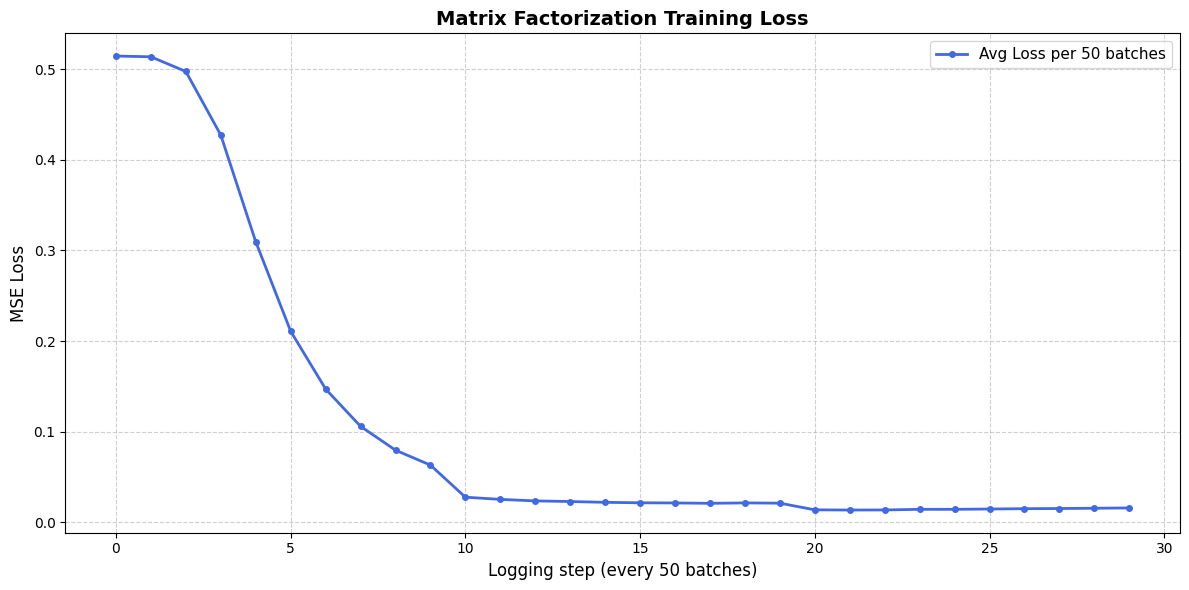

In [36]:
mf_model, user_labels, product_labels = train_matrix_factorization(
    train_df,
    latent_dim=latent_dim,
    epochs=epochs,
    lr=lr,
    batch_size=batch_size
)

In [37]:
torch.save(mf_model.state_dict(), models_dir / f'mf_model_latent_dim_{latent_dim}_epochs_{epochs}_lr_{lr}.pth')

with open(models_outputs_dir / 'mf' / 'user_labels.pkl', 'wb') as f:
    pickle.dump(user_labels, f)

with open(models_outputs_dir / 'mf' / 'product_labels.pkl', 'wb') as f:
    pickle.dump(product_labels, f)

mf_model.eval()

MatrixFactorization(
  (user_factors): Embedding(130282, 256)
  (item_factors): Embedding(202924, 256)
)

In [ ]:
with open(models_outputs_dir / 'mf' / 'user_labels.pkl', "rb") as f:
    user_labels = pickle.load(f)

with open(models_outputs_dir / 'mf' / 'product_labels.pkl', "rb") as f:
    product_labels = pickle.load(f)

# Reconstruct the model architecture
num_users = len(user_labels)
num_items = len(product_labels)

mf_model = MatrixFactorization(num_users, num_items, latent_dim).to(device)

# Load model weights
mf_model.load_state_dict(torch.load(models_dir / f'mf_model_latent_dim_{latent_dim}_epochs_{epochs}_lr_{lr}.pth'))

# Switch model to evaluation (inference) mode
mf_model.eval()

MatrixFactorization(
  (user_factors): Embedding(370091, 512)
  (item_factors): Embedding(267600, 512)
)

In [ ]:
# Importing saved recommendations
with open(models_outputs_dir / 'mf' / 'user_recommendations_mf.pkl', "rb") as f:
    user_recommendations_mf = pickle.load(f)

In [40]:
# Generation of new recommendations
user_ids = test_df['anon_id_encrypred'].unique()

user_recommendations_mf = recommend_mf_batch(
    user_ids=user_ids[:len(user_ids) // 10],
    model=mf_model,
    user_labels=user_labels,
    product_labels=product_labels,
    df=train_df,
    top_k_items=k,
    batch_size=2,
    filter_already_purchased=filter_already_purchased
)

with open(models_outputs_dir / 'mf' / 'user_recommendations_mf.pkl', 'wb') as f:
    pickle.dump(user_recommendations_mf, f)

Generating MF recommendations:   0%|          | 0/3973 [00:00<?, ?it/s]

In [41]:
dataset_mf = RecommendationDataset(user_recommendations=user_recommendations_mf, user_to_true_items=test_user_to_true_items, k=k)
loader = DataLoader(dataset_mf, batch_size=batch_size, num_workers=0, 
                    collate_fn=lambda batch: collate_fn(batch, device='mps'))

In [42]:
precision_k = precision_at_k_gpu(loader=loader, k=k)
print(f'Precision@{k} for MF model: {precision_k:.8f}')

recall_k = recall_at_k_gpu(loader=loader, k=k)
print(f'Recall@{k} for MF model: {recall_k:8f}')

map_k = map_at_k_gpu(loader=loader, k=k)
print(f'MAP@{k} for MF model: {map_k:.8f}')

ndcg_k = ndcg_at_k_gpu(loader=loader, k=k)
print(f'NDCG@{k} for MF model: {ndcg_k:.8f}')

Precision@K:   0%|          | 0/8 [00:00<?, ?it/s]

Precision@10 for MF model: 0.00028945


Recall@K:   0%|          | 0/8 [00:00<?, ?it/s]

Recall@10 for MF model: 0.000264


MAP@K:   0%|          | 0/8 [00:00<?, ?it/s]

MAP@10 for MF model: 0.00006727


NDCG@K:   0%|          | 0/8 [00:00<?, ?it/s]

NDCG@10 for MF model: 0.00018895


In [43]:
log_model_results(model_name='Matrix Factorization', k=k, precision_k=precision_k, recall_k=recall_k, map_k=map_k, ndcg_k=ndcg_k, round_level=round_level,
                  hyperparameters={'top_k_items': k, 'latent_dim': latent_dim, 
                                   'filter_already_purchased': filter_already_purchased})
df_metrics

,Model,k,Precision@k,Recall@k,MAP@k,NDCG@k,Other_hyperparameters
0,Top-K,10,0.005779,0.005419,0.002633,0.004834,None
1,Random,10,0.000033,0.000032,0.000005,0.000013,None
2,UBCF,10,0.003238,0.003224,0.001730,0.002740,"{'top_k_items': 10, 'top_n_similar_users': 20,..."
3,Matrix Factorization,10,0.000289,0.000264,0.000067,0.000189,"{'top_k_items': 10, 'latent_dim': 256, 'filter..."


In [44]:
df_metrics.to_excel(interim_data_dir / f'df_metrics_k_{k}.xlsx', index=False)

## Strong Models

### BERT4Rec

https://arxiv.org/pdf/1904.06690

In [53]:
for obj in gc.get_objects():
    try:
        if isinstance(obj, torch.Tensor) and obj.is_mps: # or obj.is_cuda
            ref = weakref.ref(obj)
            del obj
            del ref
    except ReferenceError:
        pass

gc.collect()
torch.mps.empty_cache() # or torch.cuda.empty_cache()

#### BERT4Rec Base

In [8]:
class BERT4RecDataset(Dataset):
    def __init__(self, sequences, max_len, mask_prob, num_items, pad_token=0, mask_token=None, is_train=True, external_targets=None):
        self.max_len = max_len
        self.mask_prob = mask_prob
        self.num_items = num_items
        self.pad_token = pad_token
        self.mask_token = mask_token if mask_token is not None else num_items + 1
        self.is_train = is_train 
        self.external_targets = external_targets  # user_id -> true items (list or set)

        self.user_ids = []
        self.processed_sequences = []
        
        for user_id, seq in sequences:
            self.user_ids.append(user_id)
            truncated = seq[-self.max_len:] if len(seq) > self.max_len else seq
            padded = truncated + [self.pad_token] * (self.max_len - len(truncated))  # RIGHT SIDE PADDING
            self.processed_sequences.append(padded)

    def __len__(self):
        return len(self.processed_sequences)

    def __getitem__(self, idx):
        user_id = self.user_ids[idx]
        seq = self.processed_sequences[idx].copy()

        # === Validation Mode ===
        if not self.is_train and self.external_targets is not None:
            input_seq = seq
            true_items = list(self.external_targets.get(user_id, []))[:self.max_len]

            # RIGHT SIDE PADDING for labels
            padded_labels = true_items + [-100] * (self.max_len - len(true_items))  # -100 — default ignore_index (also default in CrossEntropyLoss)
            labels = torch.tensor(padded_labels, dtype=torch.long)

            attention_mask = [1 if x != self.pad_token else 0 for x in input_seq]
            position_ids = torch.arange(self.max_len, dtype=torch.long)

            return {
                "user_id": user_id,
                "input_ids": torch.tensor(input_seq, dtype=torch.long),
                "labels": labels,
                "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
                "position_ids": position_ids
            }


        # === Train Mode (with guarantee min_masked = 1) ===
        input_seq = seq.copy()
        target_seq = [-100] * self.max_len

        candidate_idxs = [i for i, token in enumerate(seq) if token != self.pad_token]
        masked_idxs = [i for i in candidate_idxs if random.random() < self.mask_prob]

        # === min_masked = 1 ===
        if len(masked_idxs) == 0 and len(candidate_idxs) > 0:
            masked_idxs = [random.choice(candidate_idxs)]

        for i in masked_idxs: # 90, 9, 1
            original_token = seq[i]
            prob = random.random()
            if prob < 0.9:
                input_seq[i] = self.mask_token
            elif prob < 0.99:
                input_seq[i] = random.randint(1, self.num_items)
            else:
                input_seq[i] = original_token
            target_seq[i] = original_token

        attention_mask = [1 if x != self.pad_token else 0 for x in input_seq]
        position_ids = torch.arange(self.max_len, dtype=torch.long)

        return {
            "user_id": user_id,
            "input_ids": torch.tensor(input_seq, dtype=torch.long),
            "labels": torch.tensor(target_seq, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "position_ids": position_ids
        }


In [9]:
df_sales_articul['order_date'] = pd.to_datetime(df_sales_articul['order_date'])
df_sales_articul = df_sales_articul.sort_values(by=['anon_id_encrypred', 'order_date'])

# Leave only users with 5+ purchases (for decreasing the noise)
user_counts = df_sales_articul['anon_id_encrypred'].value_counts()
active_users = user_counts[user_counts >= 5].index
df_sales_articul = df_sales_articul[df_sales_articul['anon_id_encrypred'].isin(active_users)]

# Index mapping
unique_articul_encrypred_id = df_sales_articul['articul_encrypred_id'].unique()
articul_encrypred_id_to_idx = {pid: idx + 1 for idx, pid in enumerate(unique_articul_encrypred_id)} # + 1 for PAD zero token (0)
df_sales_articul['articul_encrypred_idx'] = df_sales_articul['articul_encrypred_id'].map(articul_encrypred_id_to_idx)

# Train/Test time split
threshold_level = 0.85
min_date = df_sales_articul['order_date'].min()
max_date = df_sales_articul['order_date'].max()

print(f"Min date: {min_date}")
print(f"Max date: {max_date}")

total_days = (max_date - min_date).days
threshold_days = int(total_days * threshold_level)
threshold_date = min_date + pd.Timedelta(days=threshold_days)

print(f"Threshold date ({round(threshold_level * 100, 0)}%): {threshold_date}")

train_df = df_sales_articul[df_sales_articul['order_date'] < threshold_date]
test_df = df_sales_articul[df_sales_articul['order_date'] >= threshold_date]

df_sales_articul.to_csv(interim_data_dir / 'df_sales_articul.csv', index=False)
train_df.to_csv(interim_data_dir / 'train_data_by_threshold_date.csv', index=False)
test_df.to_csv(interim_data_dir / 'test_data_by_threshold_date.csv', index=False)

# df_sales_articul = pd.read_csv(interim_data_dir / 'df_sales_articul.csv')
# train_df = pd.read_csv(interim_data_dir / 'train_data_by_threshold_date.csv')
# test_df = pd.read_csv(interim_data_dir / 'test_data_by_threshold_date.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print()
print(f"Total number of users: {len(df_sales_articul['anon_id_encrypred'].unique())}")
print(f"Number of users in the training set: {len(train_df['anon_id_encrypred'].unique())}")
print(f"Number of users in the test set: {len(test_df['anon_id_encrypred'].unique())}")
print()
print(f"Total number of 'articul_encrypred_idx': {len(df_sales_articul['articul_encrypred_idx'].unique())}")
print(f"Number of 'articul_encrypred_idx' in the training set: {len(train_df['articul_encrypred_idx'].unique())}")
print(f"Number of 'articul_encrypred_idx' in the test set: {len(test_df['articul_encrypred_idx'].unique())}")

test_user_to_true_items = test_df.groupby('anon_id_encrypred')['articul_encrypred_idx'].apply(set).to_dict()

Min date: 2019-01-01 00:00:00
Max date: 2021-02-18 00:00:00
Threshold date (85.0%): 2020-10-24 00:00:00
Train shape: (2361946, 7)
Test shape: (445954, 7)

Total number of users: 134362
Number of users in the training set: 130282
Number of users in the test set: 79468

Total number of 'articul_encrypred_idx': 222135
Number of 'articul_encrypred_idx' in the training set: 202924
Number of 'articul_encrypred_idx' in the test set: 99765


In [10]:
# Group by users and compute the sequence length for each
user_sequence_lengths = df_sales_articul.groupby('anon_id_encrypred').size()
percentiles = user_sequence_lengths.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

print("Sequence length percentiles:")
print(percentiles)
print(f"Maximum sequence length: {user_sequence_lengths.max()}")


Sequence length percentiles:
0.25      7.0
0.50     11.0
0.75     21.0
0.90     44.0
0.95     68.0
0.99    159.0
dtype: float64
Maximum sequence length: 2192


In [11]:
# Create purchase sequences for each user
train_sequences = train_df.groupby('anon_id_encrypred')['articul_encrypred_idx'].apply(list).to_dict()
test_sequences = test_df.groupby('anon_id_encrypred')['articul_encrypred_idx'].apply(list).to_dict()

print(f"Example sequence for user {list(train_sequences.keys())[0]}: {train_sequences[list(train_sequences.keys())[0]]}")

Example sequence for user qqwrtrxq: [1, 2, 3, 4]


In [12]:
max_len = 15 # Maximum sequence length
mask_prob = 0.5 # Masking probability
num_items = len(articul_encrypred_id_to_idx) 

# Convert sequence dictionaries to list of tuples (user_id, sequence)
train_sequences_list = list(train_sequences.items())
test_sequences_list = list(test_sequences.items())

train_dataset = BERT4RecDataset(
    sequences=train_sequences_list,
    max_len=max_len,
    mask_prob=mask_prob,
    num_items=num_items,
    is_train=True
)

test_dataset = BERT4RecDataset(
    sequences=train_sequences_list,     # <-- train for inputs
    max_len=max_len,
    mask_prob=mask_prob,
    num_items=num_items,
    is_train=False,
    external_targets=test_sequences  # <-- targets from test_df
)

batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [13]:
for batch in train_loader:
    print('One object from `train_loader`')
    user_ids = batch['user_id'][0]
    input_ids = batch['input_ids'][0]
    labels = batch['labels'][0]
    attention_mask = batch['attention_mask'][0]
    position_ids = batch['position_ids'][0]
    
    print("User ID:", user_ids)
    print("Input IDs:", input_ids)
    print("Labels:", labels)
    print("Attention Mask:", attention_mask)
    print("Position IDs:", position_ids)
    break 

print()

for batch in test_loader:
    print('One object from `test_dataset`')
    user_ids = batch['user_id'][0]
    input_ids = batch['input_ids'][0]
    labels = batch['labels'][0]
    attention_mask = batch['attention_mask'][0]
    position_ids = batch['position_ids'][0]
    
    print("User ID:", user_ids)
    print("Input IDs:", input_ids)
    print("Labels:", labels)
    print("Attention Mask:", attention_mask)
    print("Position IDs:", position_ids)
    break 

One object from `train_loader`
User ID: wyyypqqtqyqvxvwr
Input IDs: tensor([222136,  25379,  48230, 222136, 222136,  95061, 222136,  69611,  58895,
         30343,   3187,  23052, 222136, 222136,   7247])
Labels: tensor([ 5744,  -100,  -100, 17434, 26453,  -100, 47944,  -100,  -100,  -100,
         -100,  -100, 57116, 23802,  -100])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Position IDs: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

One object from `test_dataset`
User ID: qqwrtrxq
Input IDs: tensor([1, 2, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Labels: tensor([   5, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100])
Attention Mask: tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Position IDs: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])


In [14]:
class BERT4RecModel(nn.Module):
    def __init__(self,
                 num_items,
                 max_len,
                 embedding_dim=256,
                 num_layers=6,
                 num_heads=4,
                 dropout=0.1,
                 ffn_dim=1024):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_items = num_items
        self.max_len = max_len

        # PAD = 0, items = 1..num_items, MASK = num_items+1
        self.item_embeddings = nn.Embedding(num_items + 2, embedding_dim, padding_idx=0)
        self.position_embeddings = nn.Embedding(max_len, embedding_dim)
        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout)

        encoder_layer = TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=ffn_dim,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.transformer = TransformerEncoder(encoder_layer,
                                              num_layers=num_layers)

        # ——— Новая классифицирующая голова ———
        # Проецируем обратно в embedding_dim, чтобы можно было dot-product'ом
        self.fc_head = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim * 2),
            nn.GELU(),
            nn.LayerNorm(embedding_dim * 2),
            nn.Linear(embedding_dim * 2, embedding_dim, bias=False),
            # nn.LayerNorm(embedding_dim),  
        )
        # bias для logits по словарю
        self.vocab_bias = nn.Parameter(torch.zeros(num_items + 2))

        # weight-tying: последний Linear выдаёт embedding_dim,
        # а дальше dot(item_emb.weight.T) дает logits по vocab
        # (embedding_dim == self.item_embeddings.embedding_dim)

        self._init_weights()

    def _init_weights(self):
        # эмбеддинги
        nn.init.xavier_uniform_(self.item_embeddings.weight)
        # nn.init.normal_(self.item_embeddings.weight, 0.0, 0.02)
        nn.init.normal_(self.position_embeddings.weight, 0.0, 0.02)

        # трансформер
        for layer in self.transformer.layers:
            nn.init.xavier_uniform_(layer.self_attn.in_proj_weight)
            nn.init.xavier_uniform_(layer.self_attn.out_proj.weight)
            nn.init.xavier_uniform_(layer.linear1.weight)
            nn.init.xavier_uniform_(layer.linear2.weight)

        # голова
        nn.init.xavier_uniform_(self.fc_head[0].weight)
        nn.init.xavier_uniform_(self.fc_head[3].weight)
        nn.init.zeros_(self.vocab_bias)

    def forward(self, input_ids, attention_mask, position_ids):
        B, L = input_ids.size()
        # 1) Embeddings + scale
        item_embeds = self.item_embeddings(input_ids)             # (B,L,dim)
        pos_embeds  = self.position_embeddings(position_ids)      # (L,dim) -> broadcast
        x = (item_embeds + pos_embeds) * math.sqrt(self.embedding_dim)
        x = self.layer_norm(x)
        x = self.dropout(x)

        # 2) Causal + padding masks
        src_key_padding_mask = (attention_mask == 0)              # (B,L)

        # 3) Transformer
        x = self.transformer(x, src_key_padding_mask=src_key_padding_mask)  # (B,L,dim)

        # 4) Head → back to embedding space
        h = self.fc_head(x)                                      # (B,L,dim)

        # 5) Dot-product with item_embeddings + bias → logits
        logits = torch.matmul(h, self.item_embeddings.weight.T)  # (B,L,num_items+2)
        logits = logits + self.vocab_bias                        # broadcast bias

        return logits

In [15]:
def train_model(
    model: nn.Module,
    train_loader,
    val_loader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    save_path: str,
    num_epochs: int = 5,
    log_interval: int = 50,
    scheduler = None,
):
    """
    Тренирует модель с выводом прогресса через tqdm и периодическим логированием лосса.
    Возвращает модель и историю лоссов.
    """
    criterion = nn.CrossEntropyLoss(ignore_index=-100, label_smoothing=0.1) # label_smoothing=0.1 размывание таргета
    best_val_loss = float("inf")

    train_loss_history = []
    val_loss_history = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        # running_loss = 0.0
        running, acc_steps = 0.0, 0

        for n,p in model.named_parameters():
            assert torch.all(torch.isfinite(p)), f"NaN в параметре {n}"


        # оборачиваем сам loader, а затем делаем enumerate над tqdm-ом
        pbar_train = tqdm(train_loader, total=len(train_loader),
                          desc=f"[Epoch {epoch}/{num_epochs}] Train")
        for batch_idx, batch in enumerate(pbar_train, 1):
            try:
                input_ids      = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                position_ids   = batch['position_ids'].to(device)
                labels         = batch['labels'].to(device)

                # === ✅ ДОПОЛНИТЕЛЬНАЯ ПРОВЕРКА ПЕРЕД LOSS ===
                # print(f"[Batch {batch_idx}] input_ids: min={input_ids.min().item()}, max={input_ids.max().item()}")
                # print(f"[Batch {batch_idx}] labels:    min={labels[labels != -100].min().item() if (labels != -100).any() else 'n/a'}, "
                #     f"max={labels[labels != -100].max().item() if (labels != -100).any() else 'n/a'}")

                # Проверка на допустимые значения
                assert torch.all((labels == -100) | ((labels > 0) & (labels < num_items + 1))), \
                    f"Invalid label value found! batch_idx={batch_idx}"

                assert input_ids.max() < num_items + 2, f"input_ids contain invalid token! batch_idx={batch_idx}"

                if not (labels != -100).any():
                    print(f"[Batch {batch_idx}] All masked, skipping")
                    pbar_train.update(1)
                    continue

                optimizer.zero_grad()

                outputs = model(input_ids, attention_mask, position_ids)
                loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))

                if not torch.isfinite(loss):
                    print(f"!!! NaN loss at epoch {epoch} batch {batch_idx}")

                    for name, p in model.named_parameters():
                        if not torch.all(torch.isfinite(p)):
                            bad = (~torch.isfinite(p)).sum().item()
                            print(f"  → {name}: {bad} bad entries")
                    raise RuntimeError("Stop: loss became NaN")
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                if scheduler is not None:
                    scheduler.step()

                running += loss.item()
                acc_steps += 1

                if batch_idx % 500 == 0:
                    print(f"[Batch {batch_idx}] shape: input_ids={input_ids.shape}, labels={labels.shape}, outputs={outputs.shape}")
                    current_lr = scheduler.get_last_lr()[0]
                    print(f"[Batch {batch_idx}] lr = {current_lr:.8f}")


                # log n первых/каждый log_interval
                if batch_idx == 1 or (acc_steps % log_interval == 0):
                    avg = running / acc_steps
                    pbar_train.set_postfix(batch_loss=f"{avg:.4f}")
                    train_loss_history.append(avg)
                    running, acc_steps = 0.0, 0

            except Exception as e:
                print(f"Error at batch {batch_idx}: {e}")


        # ---- Validation ----
        model.eval()
        # val_running = 0.0
        val_running, val_batches = 0.0, 0

        with torch.no_grad():
            pbar_val = tqdm(val_loader, total=len(val_loader),
                            desc=f"[Epoch {epoch}/{num_epochs}] Val  ")
            for batch in pbar_val:
                input_ids      = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                position_ids   = batch['position_ids'].to(device)
                labels         = batch['labels'].to(device)

                if (labels != -100).any():           # есть валид-таргеты
                    outputs = model(input_ids, attention_mask, position_ids)
                    loss    = criterion(
                        outputs.view(-1, outputs.size(-1)),
                        labels.view(-1)
                    )
                    val_running += loss.item()
                    val_batches += 1
                    pbar_val.set_postfix(val_loss=f"{loss.item():.4f}")
                else:
                    pbar_val.set_postfix(val_loss="skip")

        avg_val = val_running / val_batches if val_batches else float("nan")
        val_loss_history.append(avg_val)
        print(f"Epoch {epoch}: val_loss = {avg_val:.4f}")

        # сохраняем лучшую модель
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            torch.save(model.state_dict(), save_path)
            print(f"→ saved new best model  (val_loss {best_val_loss:.4f})\n")

    return model, train_loss_history, val_loss_history

In [13]:
embedding_dim=1024
num_layers=12
num_heads=8
ffn_dim=4096
dropout=0.1
lr=1e-4
log_interval=100

model = BERT4RecModel(
    num_items=num_items,
    max_len=max_len,
    embedding_dim=embedding_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    ffn_dim=ffn_dim,
    dropout=dropout
).to(device)

optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-3)

num_epochs = 3
total_steps = num_epochs * len(train_loader)
warmup_steps = int(0.1 * total_steps)

scheduler = LambdaLR(optimizer,
    lr_lambda=lambda step: (step / warmup_steps if step < warmup_steps
        else max(0.0, (total_steps - step) / float(max(1, total_steps - warmup_steps)))
    )
)

save_path = models_dir / f'bert4rec_model_articul_encrypred_id_embedding_dim_{embedding_dim}_epochs_{num_epochs}_lr_{lr}_max_len_{max_len}_mask_prob_{mask_prob}_num_layers_{num_layers}_num_heads_{num_heads}_ffn_dim_{ffn_dim}_dropout_{dropout}_num_items_{num_items}.pth'

In [14]:
model

BERT4RecModel(
  (item_embeddings): Embedding(222137, 1024, padding_idx=0)
  (position_embeddings): Embedding(15, 1024)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (linear1): Linear(in_features=1024, out_features=4096, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=4096, out_features=1024, bias=True)
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc_head): Sequential(
    (0): Linear(in_fea

In [ ]:
trained_model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    log_interval=log_interval,
    save_path=save_path,
    scheduler=scheduler
)

torch.save(trained_model.state_dict(), models_dir / f'LAST_EPOCH_bert4rec_model_embedding_dim_{embedding_dim}_epochs_{num_epochs}_lr_{lr}_max_len_{max_len}_mask_prob_{mask_prob}_num_layers_{num_layers}_num_heads_{num_heads}_ffn_dim_{ffn_dim}_dropout_{dropout}_num_items_{num_items}.pth')

print(f"Last train loss = {train_losses[-1]:.4f}")
print(f"Last val loss = {val_losses[-1]:.4f}")

[Epoch 1/3] Train:   0%|          | 0/4072 [00:00<?, ?it/s]

[Batch 500] shape: input_ids=torch.Size([32, 15]), labels=torch.Size([32, 15]), outputs=torch.Size([32, 15, 222137])
[Batch 500] lr = 0.00004095
[Batch 1000] shape: input_ids=torch.Size([32, 15]), labels=torch.Size([32, 15]), outputs=torch.Size([32, 15, 222137])
[Batch 1000] lr = 0.00008190


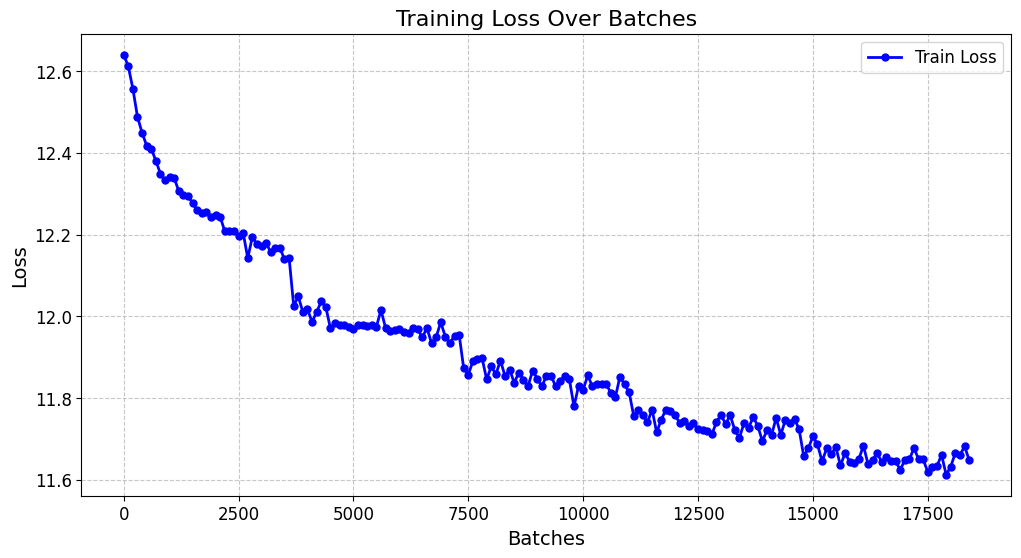

In [ ]:
def plot_train_loss(train_losses, log_interval, name='Loss Over Batches'):
    """
    Визуализация train_losses.
    
    :param train_losses: Список значений потерь на тренировке.
    :param log_interval: Интервал логирования (для корректной оси X).
    """
    plt.figure(figsize=(12, 6))
    
    # Ось X: количество батчей
    x = [i * log_interval for i in range(len(train_losses))]
    
    # Отрисовка графика
    plt.plot(x, train_losses, label='Train Loss', marker='o', color='blue', linestyle='-', linewidth=2, markersize=5)
    
    # Настройки графика
    plt.title(name, fontsize=16)
    plt.xlabel('Batches', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Отображение графика
    plt.show()

# Пример использования после обучения
plot_train_loss(train_losses, log_interval=log_interval, name='Training Loss Over Batches')
plot_train_loss(val_losses, log_interval=100, name='Validation Loss Over Batches')

#### BERT4Rec + Content embeddings

In [9]:
class BERT4RecDataset(Dataset):
    def __init__(self, sequences, max_len, mask_prob, num_items, pad_token=0, mask_token=None, is_train=True, external_targets=None):
        self.max_len = max_len
        self.mask_prob = mask_prob
        self.num_items = num_items
        self.pad_token = pad_token
        self.mask_token = mask_token if mask_token is not None else num_items + 1
        self.is_train = is_train 
        self.external_targets = external_targets  # user_id -> true items (list or set)

        self.user_ids = []
        self.processed_sequences = []
        
        for user_id, seq in sequences:
            self.user_ids.append(user_id)
            truncated = seq[-self.max_len:] if len(seq) > self.max_len else seq
            padded = truncated + [self.pad_token] * (self.max_len - len(truncated))  # RIGHT SIDE PADDING
            self.processed_sequences.append(padded)

    def __len__(self):
        return len(self.processed_sequences)

    def __getitem__(self, idx):
        user_id = self.user_ids[idx]
        seq = self.processed_sequences[idx].copy()

        # === Validation Mode ===
        if not self.is_train and self.external_targets is not None:
            input_seq = seq
            true_items = list(self.external_targets.get(user_id, []))[:self.max_len]

            # RIGHT SIDE PADDING for labels
            padded_labels = true_items + [-100] * (self.max_len - len(true_items))  # -100 — default ignore_index (also default in CrossEntropyLoss)
            labels = torch.tensor(padded_labels, dtype=torch.long)

            attention_mask = [1 if x != self.pad_token else 0 for x in input_seq]
            position_ids = torch.arange(self.max_len, dtype=torch.long)

            return {
                "user_id": user_id,
                "input_ids": torch.tensor(input_seq, dtype=torch.long),
                "labels": labels,
                "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
                "position_ids": position_ids
            }


        # === Train Mode (with guarantee min_masked = 1) ===
        input_seq = seq.copy()
        target_seq = [-100] * self.max_len

        candidate_idxs = [i for i, token in enumerate(seq) if token != self.pad_token]
        masked_idxs = [i for i in candidate_idxs if random.random() < self.mask_prob]

        # === min_masked = 1 ===
        if len(masked_idxs) == 0 and len(candidate_idxs) > 0:
            masked_idxs = [random.choice(candidate_idxs)]

        for i in masked_idxs: # 90, 9, 1
            original_token = seq[i]
            prob = random.random()
            if prob < 0.9:
                input_seq[i] = self.mask_token
            elif prob < 0.99:
                input_seq[i] = random.randint(1, self.num_items)
            else:
                input_seq[i] = original_token
            target_seq[i] = original_token

        attention_mask = [1 if x != self.pad_token else 0 for x in input_seq]
        position_ids = torch.arange(self.max_len, dtype=torch.long)

        return {
            "user_id": user_id,
            "input_ids": torch.tensor(input_seq, dtype=torch.long),
            "labels": torch.tensor(target_seq, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "position_ids": position_ids
        }


In [11]:
# df_sales_articul['order_date'] = pd.to_datetime(df_sales_articul['order_date'])
# df_sales_articul = df_sales_articul.sort_values(by=['anon_id_encrypred', 'order_date'])

# # Leave only users with 5+ purchases (for decreasing the noise)
# user_counts = df_sales_articul['anon_id_encrypred'].value_counts()
# active_users = user_counts[user_counts >= 5].index
# df_sales_articul = df_sales_articul[df_sales_articul['anon_id_encrypred'].isin(active_users)]

# # Index mapping
# unique_articul_encrypred_id = df_sales_articul['articul_encrypred_id'].unique()
# articul_encrypred_id_to_idx = {pid: idx + 1 for idx, pid in enumerate(unique_articul_encrypred_id)} # + 1 for PAD zero token (0)
# df_sales_articul['articul_encrypred_idx'] = df_sales_articul['articul_encrypred_id'].map(articul_encrypred_id_to_idx)
# num_items = len(articul_encrypred_id_to_idx) 

# # Train/Test time split
# threshold_level = 0.85
# min_date = df_sales_articul['order_date'].min()
# max_date = df_sales_articul['order_date'].max()

# print(f"Min date: {min_date}")
# print(f"Max date: {max_date}")

# total_days = (max_date - min_date).days
# threshold_days = int(total_days * threshold_level)
# threshold_date = min_date + pd.Timedelta(days=threshold_days)

# print(f"Threshold date ({round(threshold_level * 100, 0)}%): {threshold_date}")

# train_df = df_sales_articul[df_sales_articul['order_date'] < threshold_date]
# test_df = df_sales_articul[df_sales_articul['order_date'] >= threshold_date]

# df_sales_articul.to_csv(interim_data_dir / 'df_sales_articul.csv', index=False)
# train_df.to_csv(interim_data_dir / 'train_data_by_threshold_date.csv', index=False)
# test_df.to_csv(interim_data_dir / 'test_data_by_threshold_date.csv', index=False)

df_sales_articul = pd.read_csv(interim_data_dir / 'df_sales_articul.csv')
train_df = pd.read_csv(interim_data_dir / 'train_data_by_threshold_date.csv')
test_df = pd.read_csv(interim_data_dir / 'test_data_by_threshold_date.csv')
# Reconstructing the articul_encrypred_id_to_idx dictionary from the dataframe
articul_encrypred_id_to_idx = dict(df_sales_articul[['articul_encrypred_id', 'articul_encrypred_idx']].drop_duplicates().values)
num_items = len(articul_encrypred_id_to_idx)

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print()
print(f"Total number of users: {len(df_sales_articul['anon_id_encrypred'].unique())}")
print(f"Number of users in the training set: {len(train_df['anon_id_encrypred'].unique())}")
print(f"Number of users in the test set: {len(test_df['anon_id_encrypred'].unique())}")
print()
print(f"Total number of 'articul_encrypred_idx': {len(df_sales_articul['articul_encrypred_idx'].unique())}")
print(f"Number of 'articul_encrypred_idx' in the training set: {len(train_df['articul_encrypred_idx'].unique())}")
print(f"Number of 'articul_encrypred_idx' in the test set: {len(test_df['articul_encrypred_idx'].unique())}")

test_user_to_true_items = test_df.groupby('anon_id_encrypred')['articul_encrypred_idx'].apply(set).to_dict()

Train shape: (2361946, 7)
Test shape: (445954, 7)

Total number of users: 134362
Number of users in the training set: 130282
Number of users in the test set: 79468

Total number of 'articul_encrypred_idx': 222135
Number of 'articul_encrypred_idx' in the training set: 202924
Number of 'articul_encrypred_idx' in the test set: 99765


In [12]:
# embedding_cols = [
#     'CLS_google_vit_huge_patch14_224_in21k',
#     'mean_patch_google_vit_huge_patch14_224_in21k',
#     'pooled_google_vit_huge_patch14_224_in21k',
#     'pooled_microsoft_resnet50',
#     'CLS_openai_clip_vit_large_patch14',
#     'mean_patch_openai_clip_vit_large_patch14',
#     'pooled_openai_clip_vit_large_patch14',
#     'embedding_e5_large_v2',
#     'embedding_bge_large_en_v15',
#     'embedding_nomic_embed_text_v15',
# ]

# extra_numeric_cols = ['product_created_at_day', 'sales_total']

# embedding_dim = sum(len(df_products_articul[col].iloc[0]) for col in embedding_cols) + len(extra_numeric_cols)

# # [num_items + 2, embedding_dim]
# item_features_matrix = np.zeros((num_items + 2, embedding_dim), dtype=np.float32)

# for _, row in df_products_articul.iterrows():
#     pid = row['articul_encrypred_id']
#     idx = articul_encrypred_id_to_idx.get(pid)
#     if idx is None:
#         continue

#     vec = []
#     for col in embedding_cols:
#         vec.extend(row[col])  # col — list with float
#     for col in extra_numeric_cols:
#         vec.append(float(row[col]))
    
#     item_features_matrix[idx] = np.array(vec, dtype=np.float32)

# item_features_tensor = torch.tensor(item_features_matrix)  # [num_items + 2, embedding_dim]

# assert sum(item_features_tensor[0]) == sum(item_features_tensor[-1]) == 0, f"PAD or MASK tokens have non-zero embeddings!"

# # Save
# np.save(interim_data_dir / 'item_features_tensor.npy', item_features_tensor.cpu().numpy())

# Load
item_features_tensor = torch.from_numpy(np.load(interim_data_dir / 'item_features_tensor.npy')).float().to(device)

In [13]:
# Group by users and compute the sequence length for each
user_sequence_lengths = df_sales_articul.groupby('anon_id_encrypred').size()
percentiles = user_sequence_lengths.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

print("Sequence length percentiles:")
print(percentiles)
print(f"Maximum sequence length: {user_sequence_lengths.max()}")


Sequence length percentiles:
0.25      7.0
0.50     11.0
0.75     21.0
0.90     44.0
0.95     68.0
0.99    159.0
dtype: float64
Maximum sequence length: 2192


In [14]:
# Create purchase sequences for each user
train_sequences = train_df.groupby('anon_id_encrypred')['articul_encrypred_idx'].apply(list).to_dict()
test_sequences = test_df.groupby('anon_id_encrypred')['articul_encrypred_idx'].apply(list).to_dict()

print(f"Example sequence for user {list(train_sequences.keys())[0]}: {train_sequences[list(train_sequences.keys())[0]]}")

Example sequence for user qqwrtrxq: [1, 2, 3, 4]


In [27]:
max_len = 20 # Maximum sequence length
mask_prob = 0.25 # Masking probability

# Convert sequence dictionaries to list of tuples (user_id, sequence)
train_sequences_list = list(train_sequences.items())
test_sequences_list = list(test_sequences.items())

train_dataset = BERT4RecDataset(
    sequences=train_sequences_list,
    max_len=max_len,
    mask_prob=mask_prob,
    num_items=num_items,
    is_train=True
)

test_dataset = BERT4RecDataset(
    sequences=train_sequences_list,     # <-- train for inputs
    max_len=max_len,
    mask_prob=mask_prob,
    num_items=num_items,
    is_train=False,
    external_targets=test_sequences  # <-- targets from test_df
)

batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [28]:
for batch in train_loader:
    print('One object from `train_loader`')
    user_ids = batch['user_id'][0]
    input_ids = batch['input_ids'][0]
    labels = batch['labels'][0]
    attention_mask = batch['attention_mask'][0]
    position_ids = batch['position_ids'][0]
    
    print("User ID:", user_ids)
    print("Input IDs:", input_ids)
    print("Labels:", labels)
    print("Attention Mask:", attention_mask)
    print("Position IDs:", position_ids)
    break 

print()

for batch in test_loader:
    print('One object from `test_dataset`')
    user_ids = batch['user_id'][0]
    input_ids = batch['input_ids'][0]
    labels = batch['labels'][0]
    attention_mask = batch['attention_mask'][0]
    position_ids = batch['position_ids'][0]
    
    print("User ID:", user_ids)
    print("Input IDs:", input_ids)
    print("Labels:", labels)
    print("Attention Mask:", attention_mask)
    print("Position IDs:", position_ids)
    break 

One object from `train_loader`
User ID: wyyypvqpqqtxpxvy
Input IDs: tensor([156245, 171638, 222136, 222136,  37442, 222136,  28303, 222136, 222136,
        144029,  33583, 222136,  98483,  47652,  81236,  19124, 171488, 222136,
        159717, 191441])
Labels: tensor([  -100,   -100, 164587,  91666,   -100,   2602,   -100, 171870,  37442,
          -100,   -100,  98983,   -100,   -100,   -100,   -100,   -100, 113009,
          -100,   -100])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Position IDs: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19])

One object from `test_dataset`
User ID: qqwrtrxq
Input IDs: tensor([1, 2, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Labels: tensor([   5, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100])
Attention Mask: tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [31]:
batch = next(iter(test_loader))
sample_input_ids = batch['input_ids'][0]
print("Input IDs:", sample_input_ids.tolist())

idx_to_articul = {v: k for k, v in articul_encrypred_id_to_idx.items()}
for idx in sample_input_ids.tolist():
    if idx == 0:
        print("PAD")
    elif idx == num_items + 1:
        print("MASK")
        
    else:
        print(f"Index: {idx} → Articul: {idx_to_articul[idx]}")

Input IDs: [1, 2, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 1 → Articul: 650
Index: 2 → Articul: 112123
Index: 3 → Articul: 60067
Index: 4 → Articul: 2464
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD


In [45]:
class BERT4RecModel(nn.Module):
    def __init__(self,
                 num_items,
                 max_len,
                 embedding_dim=256,
                 num_layers=6,
                 num_heads=4,
                 dropout=0.1,
                 ffn_dim=1024,
                 external_features=None):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_items = num_items
        self.max_len = max_len
        ext_dim = item_features_tensor.shape[1]
        proj_dim = embedding_dim // 2

        # PAD = 0, items = 1..num_items, MASK = num_items+1
        self.item_embeddings = nn.Embedding(num_items + 2, embedding_dim, padding_idx=0)
        self.position_embeddings = nn.Embedding(max_len, embedding_dim)
        self.external_embeddings = nn.Embedding.from_pretrained(external_features, freeze=True, padding_idx=0)
        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout)

        self.external_proj = nn.Sequential(
            nn.Linear(ext_dim, proj_dim),
            nn.GELU(),
            nn.LayerNorm(proj_dim)
        )

        self.combine_proj = nn.Sequential(
            nn.Linear(embedding_dim + proj_dim, embedding_dim),
            nn.GELU(),
            nn.LayerNorm(embedding_dim)
        )

        encoder_layer = TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=ffn_dim,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.transformer = TransformerEncoder(encoder_layer,
                                              num_layers=num_layers)

        # ——— Новая классифицирующая голова ———
        # Проецируем обратно в embedding_dim, чтобы можно было dot-product'ом
        self.fc_head = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim * 2),
            nn.GELU(),
            nn.LayerNorm(embedding_dim * 2),
            nn.Linear(embedding_dim * 2, embedding_dim, bias=False),
            # nn.LayerNorm(embedding_dim),  
        )
        # bias для logits по словарю
        self.vocab_bias = nn.Parameter(torch.zeros(num_items + 2))

        # weight-tying: последний Linear выдаёт embedding_dim,
        # а дальше dot(item_emb.weight.T) дает logits по vocab
        # (embedding_dim == self.item_embeddings.embedding_dim)

        self._init_weights()

    def _init_weights(self):
        # embs
        nn.init.xavier_uniform_(self.item_embeddings.weight)
        # nn.init.normal_(self.item_embeddings.weight, 0.0, 0.02)
        nn.init.normal_(self.position_embeddings.weight, 0.0, 0.02)

        # transformer
        for layer in self.transformer.layers:
            nn.init.xavier_uniform_(layer.self_attn.in_proj_weight)
            nn.init.xavier_uniform_(layer.self_attn.out_proj.weight)
            nn.init.xavier_uniform_(layer.linear1.weight)
            nn.init.xavier_uniform_(layer.linear2.weight)

        # heads
        nn.init.xavier_uniform_(self.fc_head[0].weight)
        nn.init.xavier_uniform_(self.fc_head[3].weight)
        nn.init.zeros_(self.vocab_bias)

    def forward(self, input_ids, attention_mask, position_ids):
        B, L = input_ids.size()
        # 1) Embeddings + scale
        external_embeds = self.external_embeddings(input_ids)
        external_embeds = self.external_proj(external_embeds)
        item_embeds = self.item_embeddings(input_ids)             # (B,L,dim)
        item_embeds = torch.cat([item_embeds, external_embeds], dim=-1)
        item_embeds = self.combine_proj(item_embeds)
        pos_embeds  = self.position_embeddings(position_ids)      # (L,dim) -> broadcast
        x = (item_embeds + pos_embeds) * math.sqrt(self.embedding_dim)
        x = self.layer_norm(x)
        x = self.dropout(x)

        # 2) Causal + padding masks
        src_key_padding_mask = (attention_mask == 0)              # (B,L)

        # 3) Transformer
        x = self.transformer(x, src_key_padding_mask=src_key_padding_mask)  # (B,L,dim)

        # 4) Head → back to embedding space
        h = self.fc_head(x)                                      # (B,L,dim)

        # 5) Dot-product with item_embeddings + bias → logits
        logits = torch.matmul(h, self.item_embeddings.weight.T)  # (B,L,num_items+2)
        logits = logits + self.vocab_bias                        # broadcast bias

        return logits

In [47]:
def train_model(
    model: nn.Module,
    train_loader,
    val_loader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    save_path: str,
    num_epochs: int = 5,
    log_interval: int = 50,
    scheduler = None,
):
    """
    Тренирует модель с выводом прогресса через tqdm и периодическим логированием лосса.
    Возвращает модель и историю лоссов.
    """
    criterion = nn.CrossEntropyLoss(ignore_index=-100, label_smoothing=0.1) # label_smoothing=0.1 размывание таргета
    best_val_loss = float("inf")

    train_loss_history = []
    val_loss_history = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        # running_loss = 0.0
        running, acc_steps = 0.0, 0

        for n,p in model.named_parameters():
            assert torch.all(torch.isfinite(p)), f"NaN в параметре {n}"


        # оборачиваем сам loader, а затем делаем enumerate над tqdm-ом
        pbar_train = tqdm(train_loader, total=len(train_loader),
                          desc=f"[Epoch {epoch}/{num_epochs}] Train")
        for batch_idx, batch in enumerate(pbar_train, 1):
            try:
                input_ids      = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                position_ids   = batch['position_ids'].to(device)
                labels         = batch['labels'].to(device)

                # === ✅ ДОПОЛНИТЕЛЬНАЯ ПРОВЕРКА ПЕРЕД LOSS ===
                # print(f"[Batch {batch_idx}] input_ids: min={input_ids.min().item()}, max={input_ids.max().item()}")
                # print(f"[Batch {batch_idx}] labels:    min={labels[labels != -100].min().item() if (labels != -100).any() else 'n/a'}, "
                #     f"max={labels[labels != -100].max().item() if (labels != -100).any() else 'n/a'}")

                # Проверка на допустимые значения
                assert torch.all((labels == -100) | ((labels > 0) & (labels < num_items + 1))), \
                    f"Invalid label value found! batch_idx={batch_idx}"

                assert input_ids.max() < num_items + 2, f"input_ids contain invalid token! batch_idx={batch_idx}"

                if not (labels != -100).any():
                    print(f"[Batch {batch_idx}] All masked, skipping")
                    pbar_train.update(1)
                    continue

                optimizer.zero_grad()

                outputs = model(input_ids, attention_mask, position_ids)
                loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))

                if not torch.isfinite(loss):
                    print(f"!!! NaN loss at epoch {epoch} batch {batch_idx}")

                    for name, p in model.named_parameters():
                        if not torch.all(torch.isfinite(p)):
                            bad = (~torch.isfinite(p)).sum().item()
                            print(f"  → {name}: {bad} bad entries")
                    raise RuntimeError("Stop: loss became NaN")
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                if scheduler is not None:
                    scheduler.step()

                running += loss.item()
                acc_steps += 1

                # log n первых/каждый log_interval
                if batch_idx == 1 or (acc_steps % log_interval == 0):
                    avg = running / acc_steps
                    pbar_train.set_postfix(batch_loss=f"{avg:.4f}")
                    train_loss_history.append(avg)
                    wandb.log({
                        "train/loss": avg,
                        "train/lr": scheduler.get_last_lr()[0] if scheduler else optimizer.param_groups[0]["lr"],
                        "epoch": epoch,
                        "step": (epoch - 1) * len(train_loader) + batch_idx
                    })
                    current_lr = scheduler.get_last_lr()[0] if scheduler is not None else float('nan')
                    valid_tokens = (labels != -100).sum().item()
                    masked_ratio = valid_tokens / labels.numel()
                    preds = outputs.argmax(dim=-1)
                    correct = ((preds == labels) & (labels != -100)).sum().item()
                    accuracy = correct / valid_tokens if valid_tokens else 0.0
                    max_grad = max(p.grad.abs().max().item() for p in model.parameters() if p.grad is not None)
                
                    print(
                        f"[Batch {batch_idx}] "
                        f"train/loss={avg};\n"
                        f"input_ids={input_ids.shape}, labels={labels.shape}, outputs={outputs.shape};\n"
                        f"lr={current_lr:.8f}, "
                        f"valid_tokens={valid_tokens}, masked_ratio={masked_ratio:.2%}, "
                        f"accuracy={accuracy:.2%}, max_grad={max_grad:.4f}\n"
                    )
                    running, acc_steps = 0.0, 0

            except Exception as e:
                print(f"Error at batch {batch_idx}: {e}")


        # ---- Validation ----
        model.eval()
        # val_running = 0.0
        val_running, val_batches = 0.0, 0

        with torch.no_grad():
            pbar_val = tqdm(val_loader, total=len(val_loader), desc=f"[Epoch {epoch}/{num_epochs}] Val  ")
            for batch in pbar_val:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                position_ids = batch['position_ids'].to(device)
                labels = batch['labels'].to(device)

                if (labels != -100).any():           # есть валид-таргеты
                    outputs = model(input_ids, attention_mask, position_ids)
                    loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
                    val_running += loss.item()
                    val_batches += 1
                    pbar_val.set_postfix(val_loss=f"{loss.item():.4f}")
                else:
                    pbar_val.set_postfix(val_loss="skip")

        avg_val = val_running / val_batches if val_batches else float("nan")
        val_loss_history.append(avg_val)
        print(f"Epoch {epoch}: val_loss = {avg_val:.4f}")

        # сохраняем лучшую модель
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            torch.save(model.state_dict(), save_path)
            wandb.save(str(save_path))
            print(f"→ saved new best model  (val_loss {best_val_loss:.4f})\n")

        wandb.log({
            "val/loss": avg_val,
            "epoch": epoch
        })

    wandb.finish()
    
    return model, train_loss_history, val_loss_history

In [49]:
from tqdm.notebook import tqdm

embedding_dim = 768
num_layers = 8
num_heads = 6
ffn_dim = 2048
dropout = 0.05
lr = 3e-4
log_interval = max(1, len(train_loader) // 20)
num_epochs = 10

total_steps = num_epochs * len(train_loader)
warmup_steps = int(0.1 * total_steps)

model = BERT4RecModel(
    num_items=num_items,
    max_len=max_len,
    embedding_dim=embedding_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    ffn_dim=ffn_dim,
    dropout=dropout,
    external_features=item_features_tensor
).to(device)


optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-3)


scheduler = LambdaLR(optimizer,
    lr_lambda=lambda step: (step / warmup_steps if step < warmup_steps
        else max(0.0, (total_steps - step) / float(max(1, total_steps - warmup_steps)))
    )
)

save_path = models_dir / f'bert4rec_model_articul_encrypred_id_embedding_dim_{embedding_dim}_epochs_{num_epochs}_lr_{lr}_max_len_{max_len}_mask_prob_{mask_prob}_num_layers_{num_layers}_num_heads_{num_heads}_ffn_dim_{ffn_dim}_dropout_{dropout}_num_items_{num_items}_with_external_embs.pth'

wandb.init(
    project="Recommender_System_with_LLM",
    name=f'bert4rec_model_articul_encrypred_id_embedding_dim_{embedding_dim}_epochs_{num_epochs}_lr_{lr}_max_len_{max_len}_mask_prob_{mask_prob}_num_layers_{num_layers}_num_heads_{num_heads}_ffn_dim_{ffn_dim}_dropout_{dropout}_num_items_{num_items}_with_external_embs',
    config={
        "epochs": num_epochs,
        "batch_size": batch_size,
        "lr": lr,
        "embedding_dim": embedding_dim,
        "num_layers": num_layers,
        "num_heads": num_heads,
        "ffn_dim": ffn_dim,
        "dropout": dropout,
        "max_len": max_len,
        "mask_prob": mask_prob,
        "scheduler": "linear with warmup"
    }
)

In [50]:
model

BERT4RecModel(
  (item_embeddings): Embedding(222137, 768, padding_idx=0)
  (position_embeddings): Embedding(20, 768)
  (external_embeddings): Embedding(222137, 11266, padding_idx=0)
  (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.05, inplace=False)
  (external_proj): Sequential(
    (0): Linear(in_features=11266, out_features=384, bias=True)
    (1): GELU(approximate='none')
    (2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  )
  (combine_proj): Sequential(
    (0): Linear(in_features=1152, out_features=768, bias=True)
    (1): GELU(approximate='none')
    (2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=2

In [51]:
trained_model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    log_interval=log_interval,
    save_path=save_path,
    scheduler=scheduler
)

torch.save(trained_model.state_dict(), models_dir / f'LAST_EPOCH_bert4rec_model_embedding_dim_{embedding_dim}_epochs_{num_epochs}_lr_{lr}_max_len_{max_len}_mask_prob_{mask_prob}_num_layers_{num_layers}_num_heads_{num_heads}_ffn_dim_{ffn_dim}_dropout_{dropout}_num_items_{num_items}.pth')

print(f"Last train loss = {train_losses[-1]:.4f}")
print(f"Last val loss = {val_losses[-1]:.4f}")

[Epoch 1/10] Train:   0%|          | 0/2036 [00:00<?, ?it/s]

[Batch 1] train/loss=12.320131301879883;
input_ids=torch.Size([64, 20]), labels=torch.Size([64, 20]), outputs=torch.Size([64, 20, 222137]);
lr=0.00000015, valid_tokens=186, masked_ratio=14.53%, accuracy=0.00%, max_grad=0.0867

[Batch 102] train/loss=12.284293524109492;
input_ids=torch.Size([64, 20]), labels=torch.Size([64, 20]), outputs=torch.Size([64, 20, 222137]);
lr=0.00001503, valid_tokens=209, masked_ratio=16.33%, accuracy=0.00%, max_grad=0.0517

[Batch 203] train/loss=12.08257781869114;
input_ids=torch.Size([64, 20]), labels=torch.Size([64, 20]), outputs=torch.Size([64, 20, 222137]);
lr=0.00002991, valid_tokens=176, masked_ratio=13.75%, accuracy=0.57%, max_grad=0.0441

[Batch 304] train/loss=11.986538565985047;
input_ids=torch.Size([64, 20]), labels=torch.Size([64, 20]), outputs=torch.Size([64, 20, 222137]);
lr=0.00004479, valid_tokens=187, masked_ratio=14.61%, accuracy=0.53%, max_grad=0.0777

[Batch 405] train/loss=11.962498202182278;
input_ids=torch.Size([64, 20]), labels=torch

[Epoch 1/10] Val  :   0%|          | 0/2036 [00:00<?, ?it/s]

Epoch 1: val_loss = 12.0957
→ saved new best model  (val_loss 12.0957)



RuntimeError: MPS backend out of memory (MPS allocated: 40.01 GB, other allocations: 1.91 GB, max allowed: 43.20 GB). Tried to allocate 2.33 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

#### BERT4Rec Generation and Metrics

In [ ]:
# Функция для параллельной генерации рекомендаций (на входе батч из тестового DataLoader)
def generate_parallel_recommendations(model, input_ids, attention_mask, position_ids, k=10, device=device):
    model.eval()
    with torch.no_grad():
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        position_ids = position_ids.to(device)
        
        # Получаем выходы модели: [B, seq_len, num_items+1]
        outputs = model(input_ids, attention_mask, position_ids)
        # Берем логиты последнего токена (последний временной шаг)
        logits = outputs[:, -1, :]  # размер [B, num_items+1]
        # Выбираем топ-k рекомендаций для каждого примера
        recs = torch.topk(logits, k=k, dim=-1).indices
    return recs

# Функция для последовательной генерации рекомендаций для одного пользователя
def generate_sequential_recommendations(model, initial_sequence, max_len, k=10, device=device):
    """
    Генерирует последовательные рекомендации (авторегрессивно) для одного пользователя.
    
    :param initial_sequence: Исходная последовательность (список int) без паддинга.
    :param max_len: Максимальная длина последовательности, с которой обучалась модель.
    :param k: Количество генерируемых рекомендаций.
    :param device: Устройство.
    :return: Список сгенерированных рекомендаций.
    """
    model.eval()
    generated = []
    current_seq = initial_sequence.copy()
    
    with torch.no_grad():
        for _ in range(k):
            # Если длина последовательности меньше max_len – дополняем слева паддингом (значение 0)
            if len(current_seq) < max_len:
                padded_seq = [0] * (max_len - len(current_seq)) + current_seq
            else:
                padded_seq = current_seq[-max_len:]
            
            input_ids = torch.tensor(padded_seq, dtype=torch.long, device=device).unsqueeze(0)
            attention_mask = (input_ids != 0).long()
            position_ids = torch.arange(max_len, dtype=torch.long, device=device).unsqueeze(0)
            
            outputs = model(input_ids, attention_mask, position_ids)  # [1, max_len, num_items+1]
            logits = outputs[:, -1, :]  # [1, num_items+1]
            next_token = torch.topk(logits, k=1, dim=-1).indices.squeeze().item()
            generated.append(next_token)
            current_seq.append(next_token)
    
    return generated

In [ ]:
def run_parallel_inference(model, inference_loader, k=10, device=device):
    """
    Запускает инференс на inference_loader и получает топ-K рекомендаций для каждого пользователя.
    
    :param model: Обученная модель BERT4Rec
    :param inference_loader: DataLoader без маскированных токенов (данные из train)
    :param k: Количество рекомендаций
    :param device: Устройство (CPU/GPU)
    :return: Список предсказанных рекомендаций для всех пользователей
    """
    model.eval()
    all_recommendations = []

    with torch.no_grad():
        for batch in tqdm(inference_loader, desc="Parallel Inference"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            position_ids = batch["position_ids"].to(device)

            # Генерируем k рекомендаций
            recs = generate_parallel_recommendations(model, input_ids, attention_mask, position_ids, k=k, device=device)
            
            all_recommendations.extend(recs.cpu().tolist())

    return all_recommendations


def run_sequential_inference(model, inference_loader, max_len, k=10, device=device):
    """
    Запускает последовательный инференс: для каждого пользователя из inference_loader извлекается исходная (непадённая) последовательность,
    и генерируется последовательность рекомендаций методом авторегрессии.
    
    :param model: Обученная модель BERT4Rec.
    :param inference_loader: DataLoader с данными (is_train=False).
    :param max_len: Максимальная длина последовательности.
    :param k: Количество генерируемых рекомендаций для каждого пользователя.
    :param device: Устройство.
    :return: Словарь вида {user_id: [последовательность рекомендаций]}.
    """
    model.eval()
    user_recs = {}
    
    with torch.no_grad():
        for batch in tqdm(inference_loader, desc="Sequential Inference"):
            input_ids = batch['input_ids']           # [B, max_len]
            attention_mask = batch['attention_mask']   # [B, max_len]
            user_ids = batch['user_id']                # список user_id
            
            # Для каждого пользователя в батче извлекаем исходную последовательность без паддинга
            for i in range(input_ids.shape[0]):
                # Переходим на CPU, чтобы легко работать со списками
                seq = input_ids[i].cpu().tolist()
                mask = attention_mask[i].cpu().tolist()
                # Извлекаем только те токены, где mask==1 (непаддинговые элементы)
                initial_seq = [token for token, m in zip(seq, mask) if m == 1]
                recs = generate_sequential_recommendations(model, initial_seq, max_len, k=k, device=device)
                user_recs[user_ids[i]] = recs

    return user_recs

In [ ]:
# Используем train-данные для генерации предсказаний
inference_dataset = BERT4RecDataset(sequences=train_sequences_list, max_len=max_len, mask_prob=0.0, num_items=num_items, is_train=False)
inference_loader = DataLoader(inference_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def map_recommendations_to_users(user_ids, recommendations):
    """
    Преобразует список рекомендаций в словарь {user_id: recommendations}.

    :param user_ids: Список ID пользователей из inference_loader
    :param recommendations: Список рекомендаций из parallel_recs
    :return: Словарь {user_id: [recommendations]}
    """
    user_to_recs = {user: recs for user, recs in zip(user_ids, recommendations)}
    return user_to_recs

# Получаем список пользователей из inference_loader
user_ids = inference_loader.dataset.user_ids

In [ ]:
# Параллельные предсказания (Batch Inference)
parallel_recs = run_parallel_inference(model, inference_loader, k=k, device=device)

# Создаём словарь {user_id: recommendations}
test_user_to_parallel_recs = map_recommendations_to_users(user_ids, parallel_recs)

In [ ]:
# Последовательные предсказания (Sequential Inference)
sequential_recs = run_sequential_inference(model, inference_loader, max_len=max_len, k=k, device=device)

# Создаём словарь {user_id: recommendations}
test_user_to_sequential_recs = map_recommendations_to_users(user_ids, sequential_recs)

In [ ]:
# from torch_lr_finder import TrainDataLoaderIter

# criterion = torch.nn.CrossEntropyLoss(ignore_index=0) # игнорим паддинги

# optimizer = torch.optim.AdamW(model.parameters(), 
#                              # lr=1e-5, # Было 1e-4
#                              weight_decay=0.01)

# class CustomTrainDataLoaderIter(TrainDataLoaderIter):
#     def inputs_labels_from_batch(self, batch_data):
#         # Извлекаем данные из батча
#         inputs = {
#             'input_ids': batch_data['input_ids'],          # Input IDs
#             'attention_mask': batch_data['attention_mask'], # Attention Mask
#             'position_ids': batch_data['position_ids']     # Position IDs
#         }
#         labels = batch_data['labels']  # Labels
#         return inputs, labels


# # Создаем кастомный итератор
# train_iter = CustomTrainDataLoaderIter(train_loader)

# # Инициализация LRFinder
# lr_finder = LRFinder(model, optimizer, criterion)

# # Запуск поиска learning rate
# lr_finder.range_test(train_iter, end_lr=0.1, num_iter=100)

# # Визуализация результатов
# lr_finder.plot()

# # Сброс состояния модели
# lr_finder.reset()

In [ ]:
# # Создаем экземпляр модели
# model = BERT4RecModel(
#     num_items=num_items,
#     max_len=max_len,
#     embedding_dim=256,
#     num_layers=4,       # Кол-во атеншн слоёв (Аттеншн + лин + нелин + дропаут)
#     num_heads=8,        # Головы аттеншн слоёв
#     dropout=0.1
# ).to(device)

# # Загружаем веса
# model.load_state_dict(torch.load(models_path / 'bert4rec_embedding_dim_256_num_layers_3_num_heads_4_dropout_001_lr_1e5_base.pth'))

# # Переводим модель в режим оценки
# model.eval()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from tqdm.auto import tqdm
import random

# Дополнительные импорты для работы с изображениями и текстом
from PIL import Image
import requests
from io import BytesIO
import torchvision.transforms as transforms
import torchvision.models as models
from sentence_transformers import SentenceTransformer

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
torch.mps.set_per_process_memory_fraction(0.95)  # Ограничение памяти до 80%
torch.mps.empty_cache()

#########################
# 1. Предобработка метаданных
#########################

def compute_product_meta_features(df, meta_dim=128, device="cpu"):
    """
    Вычисляет мета-вектор для каждого уникального продукта.
    Используются признаки: brand, title, color_base, ktt1 (категория) и изображение из photo_analytics.
    """
    # Инициализируем модель для текстовых эмбеддингов
    text_model = SentenceTransformer('all-MiniLM-L6-v2')
    
    # Инициализируем предобученную модель для изображений (удаляем последний классификационный слой)
    image_model = models.resnet18(pretrained=True)
    image_model.fc = nn.Identity()
    image_model = image_model.to(device)
    image_model.eval()  # замораживаем веса для извлечения признаков
    
    image_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    product_meta = {}
    unique_products = df.drop_duplicates(subset=['articul_encrypred_idx'])
    
    for _, row in tqdm(unique_products.iterrows(), desc='Data preparing', total=unique_products.shape[0]):
        articul_encrypred_idx = row['articul_encrypred_idx']
        # Объединяем текстовые признаки
        text_input = f"{row['brand']} {row['title']} {row['color_base']} {row['ktt1']}"
        text_feat = text_model.encode(text_input, convert_to_tensor=True).to(device)
        
        # Извлекаем признаки изображения
        try:
            response = requests.get(row['photo_analytics'], timeout=5)
            image = Image.open(BytesIO(response.content)).convert('RGB')
            image = image_transform(image).unsqueeze(0).to(device)  # переносим на нужное устройство
            with torch.no_grad():
                image_feat = image_model(image).squeeze(0)
        except Exception as e:
            # Если не удалось получить изображение, используем вектор нулей (размер 512)
            image_feat = torch.zeros(512, device=device)
        
        # Конкатенируем текстовые и визуальные признаки
        meta_feat = torch.cat([text_feat, image_feat], dim=0)
        # Если размер полученного вектора не совпадает с meta_dim, применяем линейную проекцию
        if meta_feat.shape[0] != meta_dim:
            proj = nn.Linear(meta_feat.shape[0], meta_dim).to(device)
            meta_feat = proj(meta_feat.unsqueeze(0)).squeeze(0)
        product_meta[articul_encrypred_idx] = meta_feat
    
    return product_meta

# Пример: объединяем train_df и test_df (или используем df_sales, если он есть)
import pandas as pd
# df_sales = pd.concat([train_df, test_df], ignore_index=True)  # если необходимо объединить

# Предположим, что у вас уже есть df_sales с нужными столбцами
product_meta_dict = compute_product_meta_features(df_sales, meta_dim=128)

# Количество уникальных товаров
num_items = df_sales['articul_encrypred_idx'].nunique()

# Формируем матрицу весов для мета-эмбеддингов размерности (num_items+2, meta_dim)
# +2 для pad (индекс 0) и mask токена (индекс num_items+1)
meta_dim = 128
meta_weights = torch.zeros(num_items + 2, meta_dim)
# Заполняем веса для индексов от 1 до num_items (предполагается, что articul_encrypred_idx начинается с 1)
for idx in range(1, num_items + 1):
    if idx in product_meta_dict:
        meta_weights[idx] = product_meta_dict[idx]
    else:
        meta_weights[idx] = torch.zeros(meta_dim)
# Для токена 0 (pad) и токена mask (num_items+1) оставляем нули

#########################
# 2. Модификация модели BERT4Rec
#########################

class BERT4RecModel(nn.Module):
    def __init__(self, num_items, max_len, meta_embedding_weights, embedding_dim=512, num_layers=6, num_heads=8, 
                 dropout=0.1, ffn_dim=2048):
        """
        Модель BERT4Rec с дополнительными метаданными продукта.
        
        :param num_items: количество уникальных товаров
        :param max_len: максимальная длина последовательности
        :param meta_embedding_weights: предвычисленная матрица мета-векторов (torch.Tensor) размером (num_items+2, meta_dim)
        :param embedding_dim: размерность эмбеддингов товара
        :param num_layers: количество слоёв трансформера
        :param num_heads: количество голов внимания
        :param dropout: dropout
        :param ffn_dim: размерность FFN
        """
        super().__init__()
        self.num_items = num_items
        self.max_len = max_len
        
        # Эмбеддинги товара (токены: индексы от 0 до num_items+1)
        self.item_embeddings = nn.Embedding(num_items + 2, embedding_dim, padding_idx=0)
        
        # Слой мета-эмбеддингов (инициализируется предвычисленными признаками)
        meta_dim = meta_embedding_weights.shape[1]
        self.meta_embedding = nn.Embedding(num_items + 2, meta_dim, padding_idx=0)
        self.meta_embedding.weight = nn.Parameter(meta_embedding_weights, requires_grad=False)  # замораживаем или можно fine-tune
        # Проекция объединённого представления (конкатенация item и meta признаков)
        self.meta_proj = nn.Linear(embedding_dim + meta_dim, embedding_dim)
        
        # Позиционные эмбеддинги
        self.position_embeddings = nn.Embedding(max_len, embedding_dim)
        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout)
        
        # Трансформерный энкодер
        encoder_layers = TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=ffn_dim,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        # Классификационная голова
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim * 2),
            nn.GELU(),
            nn.LayerNorm(embedding_dim * 2),
            nn.Linear(embedding_dim * 2, num_items + 1)  # +1 так как target начинается с 1
        )
        
        self._init_weights()

    def _init_weights(self):
        # Инициализация эмбеддингов и весов трансформера
        nn.init.normal_(self.item_embeddings.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.position_embeddings.weight, mean=0.0, std=0.02)
        for layer in self.transformer.layers:
            nn.init.xavier_uniform_(layer.self_attn.in_proj_weight)
            nn.init.xavier_uniform_(layer.self_attn.out_proj.weight)
            nn.init.xavier_uniform_(layer.linear1.weight)
            nn.init.xavier_uniform_(layer.linear2.weight)
        nn.init.xavier_uniform_(self.fc[0].weight)
        nn.init.xavier_uniform_(self.fc[3].weight)

    def forward(self, input_ids, attention_mask, position_ids):
        # Эмбеддинги товара
        item_embeds = self.item_embeddings(input_ids)
        # Мета-эмбеддинги (дополнительная информация)
        meta_embeds = self.meta_embedding(input_ids)
        # Объединяем: конкатенируем и проецируем в embedding_dim
        combined_embeds = torch.cat([item_embeds, meta_embeds], dim=-1)
        combined_embeds = self.meta_proj(combined_embeds)
        
        # Позиционные эмбеддинги
        pos_embeds = self.position_embeddings(position_ids)
        
        # Суммируем эмбеддинги и позиционные признаки, применяем LayerNorm и Dropout
        embeddings = self.layer_norm(combined_embeds + pos_embeds)
        embeddings = self.dropout(embeddings)
        
        # Маска для паддингов
        src_key_padding_mask = (attention_mask == 0)
        
        # Пропускаем через трансформер
        transformer_output = self.transformer(embeddings, src_key_padding_mask=src_key_padding_mask)
        
        # Классификационная голова
        logits = self.fc(transformer_output)
        return logits

#########################
# 3. Остальной код обучения остаётся аналогичным
#########################

# Пример создания датасетов, DataLoader и тренировки (код у вас уже есть)
# При этом BERT4RecDataset не меняется, поскольку последовательности остаются на уровне articul_encrypred_idx

# Параметры
max_len = 12          # Максимальная длина последовательности
mask_prob = 0.2       # Вероятность маскирования
batch_size = 64

# Преобразуем словари последовательностей в список кортежей (user_id, sequence)
train_sequences_list = list(train_sequences.items())
test_sequences_list = list(test_sequences.items())

# Создаём датасеты (ваш класс BERT4RecDataset не изменился)
train_dataset = BERT4RecDataset(
    sequences=train_sequences_list,
    max_len=max_len,
    mask_prob=mask_prob,
    num_items=num_items,
    is_train=True
)

test_dataset = BERT4RecDataset(
    sequences=test_sequences_list,
    max_len=max_len,
    mask_prob=mask_prob,
    num_items=num_items,
    is_train=False
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

model = BERT4RecModel(
    num_items=num_items,
    max_len=max_len,
    meta_embedding_weights=meta_weights,
    embedding_dim=256,    # например, 256
    num_layers=3,         # количество слоёв
    num_heads=4,          # количество голов
    dropout=0.01
).to(device)

# Настраиваем оптимизатор
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

# Функция тренировки (ваша, как ранее)
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=5,
    log_interval=50,
    save_path="best_model.pth",
):
    criterion = torch.nn.CrossEntropyLoss(ignore_index=0)
    best_loss = float('inf')
    
    train_loss_history = []
    val_loss_history = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        progress_bar_train = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Training, Epoch {epoch+1}/{num_epochs}')
        
        for batch_idx, batch in progress_bar_train:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            position_ids = batch['position_ids'].to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, position_ids)
            loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            running_loss += loss.item()
            if (batch_idx + 1) % log_interval == 0:
                avg_loss = running_loss / log_interval
                train_loss_history.append(avg_loss)
                running_loss = 0.0
                progress_bar_train.set_postfix(loss=avg_loss)
        
        # Валидация (если нужно, можно раскомментировать)
        # model.eval()
        # val_loss = 0.0
        # with torch.no_grad():
        #     for batch in val_loader:
        #         input_ids = batch['input_ids'].to(device)
        #         labels = batch['labels'].to(device)
        #         attention_mask = batch['attention_mask'].to(device)
        #         position_ids = batch['position_ids'].to(device)
        #         outputs = model(input_ids, attention_mask, position_ids)
        #         loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
        #         val_loss += loss.item()
        # avg_val_loss = val_loss / len(val_loader)
        # val_loss_history.append(avg_val_loss)
        # if avg_val_loss < best_loss:
        #     best_loss = avg_val_loss
        #     torch.save(model.state_dict(), save_path)
        #     print(f"New best model saved with val loss: {best_loss:.4f}")
    
    return train_loss_history, val_loss_history

# Запускаем обучение
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=5,
    log_interval=100,
    save_path="bert4rec_best.pth"
)


Data preparing:   0%|          | 19/309343 [01:21<367:54:27,  4.28s/it]


KeyboardInterrupt: 

In [124]:
# Функция для параллельной генерации рекомендаций (на входе батч из тестового DataLoader)
def generate_parallel_recommendations(model, input_ids, attention_mask, position_ids, k=6, device=device):
    model.eval()
    with torch.no_grad():
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        position_ids = position_ids.to(device)
        
        # Получаем выходы модели: [B, seq_len, num_items+1]
        outputs = model(input_ids, attention_mask, position_ids)
        # Берем логиты последнего токена (последний временной шаг)
        logits = outputs[:, -1, :]  # размер [B, num_items+1]
        # Выбираем топ-k рекомендаций для каждого примера
        recs = torch.topk(logits, k=k, dim=-1).indices
    return recs

# Функция для последовательной генерации рекомендаций для одного пользователя
def generate_sequential_recommendations(model, initial_sequence, max_len, k=6, device=device):
    """
    Генерирует последовательные рекомендации (авторегрессивно) для одного пользователя.
    
    :param initial_sequence: Исходная последовательность (список int) без паддинга.
    :param max_len: Максимальная длина последовательности, с которой обучалась модель.
    :param k: Количество генерируемых рекомендаций.
    :param device: Устройство.
    :return: Список сгенерированных рекомендаций.
    """
    model.eval()
    generated = []
    current_seq = initial_sequence.copy()
    
    with torch.no_grad():
        for _ in range(k):
            # Если длина последовательности меньше max_len – дополняем слева паддингом (значение 0)
            if len(current_seq) < max_len:
                padded_seq = [0] * (max_len - len(current_seq)) + current_seq
            else:
                padded_seq = current_seq[-max_len:]
            
            input_ids = torch.tensor(padded_seq, dtype=torch.long, device=device).unsqueeze(0)
            attention_mask = (input_ids != 0).long()
            position_ids = torch.arange(max_len, dtype=torch.long, device=device).unsqueeze(0)
            
            outputs = model(input_ids, attention_mask, position_ids)  # [1, max_len, num_items+1]
            logits = outputs[:, -1, :]  # [1, num_items+1]
            next_token = torch.topk(logits, k=1, dim=-1).indices.squeeze().item()
            generated.append(next_token)
            current_seq.append(next_token)
    
    return generated

In [125]:
def run_parallel_inference(model, inference_loader, k=6, device=device):
    """
    Запускает инференс на inference_loader и получает топ-K рекомендаций для каждого пользователя.
    
    :param model: Обученная модель BERT4Rec
    :param inference_loader: DataLoader без маскированных токенов (данные из train)
    :param k: Количество рекомендаций
    :param device: Устройство (CPU/GPU)
    :return: Список предсказанных рекомендаций для всех пользователей
    """
    model.eval()
    all_recommendations = []

    with torch.no_grad():
        for batch in tqdm(inference_loader, desc="Parallel Inference"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            position_ids = batch["position_ids"].to(device)

            # Генерируем k рекомендаций
            recs = generate_parallel_recommendations(model, input_ids, attention_mask, position_ids, k=k, device=device)
            
            all_recommendations.extend(recs.cpu().tolist())

    return all_recommendations


def run_sequential_inference(model, inference_loader, max_len, k=6, device=device):
    """
    Запускает последовательный инференс: для каждого пользователя из inference_loader извлекается исходная (непадённая) последовательность,
    и генерируется последовательность рекомендаций методом авторегрессии.
    
    :param model: Обученная модель BERT4Rec.
    :param inference_loader: DataLoader с данными (is_train=False).
    :param max_len: Максимальная длина последовательности.
    :param k: Количество генерируемых рекомендаций для каждого пользователя.
    :param device: Устройство.
    :return: Словарь вида {user_id: [последовательность рекомендаций]}.
    """
    model.eval()
    user_recs = {}
    
    with torch.no_grad():
        for batch in tqdm(inference_loader, desc="Sequential Inference"):
            input_ids = batch['input_ids']           # [B, max_len]
            attention_mask = batch['attention_mask']   # [B, max_len]
            user_ids = batch['user_id']                # список user_id
            
            # Для каждого пользователя в батче извлекаем исходную последовательность без паддинга
            for i in range(input_ids.shape[0]):
                # Переходим на CPU, чтобы легко работать со списками
                seq = input_ids[i].cpu().tolist()
                mask = attention_mask[i].cpu().tolist()
                # Извлекаем только те токены, где mask==1 (непаддинговые элементы)
                initial_seq = [token for token, m in zip(seq, mask) if m == 1]
                recs = generate_sequential_recommendations(model, initial_seq, max_len, k=k, device=device)
                user_recs[user_ids[i]] = recs

    return user_recs

In [96]:
# Используем train-данные для генерации предсказаний
inference_dataset = BERT4RecDataset(sequences=train_sequences_list, max_len=max_len, mask_prob=0.0, num_items=num_items, is_train=False)
inference_loader = DataLoader(inference_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def map_recommendations_to_users(user_ids, recommendations):
    """
    Преобразует список рекомендаций в словарь {user_id: recommendations}.

    :param user_ids: Список ID пользователей из inference_loader
    :param recommendations: Список рекомендаций из parallel_recs
    :return: Словарь {user_id: [recommendations]}
    """
    user_to_recs = {user: recs for user, recs in zip(user_ids, recommendations)}
    return user_to_recs

# Получаем список пользователей из inference_loader
user_ids = inference_loader.dataset.user_ids

In [ ]:
# Параллельные предсказания (Batch Inference)
parallel_recs = run_parallel_inference(model, inference_loader, k=k, device=device)

# Создаём словарь {user_id: recommendations}
test_user_to_parallel_recs = map_recommendations_to_users(user_ids, parallel_recs)

In [ ]:
# Последовательные предсказания (Sequential Inference)
sequential_recs = run_sequential_inference(model, inference_loader, max_len=max_len, k=k, device=device)

# Создаём словарь {user_id: recommendations}
test_user_to_sequential_recs = map_recommendations_to_users(user_ids, sequential_recs)

Sequential Inference:   0%|          | 0/8541 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [110]:
dataset_bert4rec_classic_parallel = RecommendationDataset(user_recommendations=test_user_to_parallel_recs, user_to_true_items=test_user_to_true_items, k=k)
loader = DataLoader(dataset_bert4rec_classic_parallel, batch_size=batch_size, collate_fn=collate_fn, num_workers=0)

In [112]:
precision_k = precision_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'Precision@k: {precision_k:.5f}')

recall_k = recall_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'Recall@k: {recall_k:5f}')

map_k = map_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'MAP@k: {map_k:.5f}')

ndcg_k = ndcg_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'NDCG@k: {ndcg_k:.5f}')

Precision@K:   0%|          | 0/8541 [00:00<?, ?it/s]

Precision@k: 0.00379


Recall@K:   0%|          | 0/8541 [00:00<?, ?it/s]

Recall@k: 0.003697


MAP@K:   0%|          | 0/8541 [00:00<?, ?it/s]

MAP@k: 0.00156


NDCG@K:   0%|          | 0/8541 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
log_model_results(model_name='Top-K', k=k, precision_k=precision_k, recall_k=recall_k, map_k=map_k, ndcg_k=ndcg_k, hyperparameters=None)
df_metrics

In [25]:
import gc
import weakref

for obj in gc.get_objects():
    try:
        if isinstance(obj, torch.Tensor) and obj.is_mps:
            ref = weakref.ref(obj)
            del obj
            del ref
    except ReferenceError:
        pass

gc.collect()
torch.mps.empty_cache()

### BERT4Rec Git version
https://github.com/asash/bert4rec_repro